# Trending YouTube Videos Statistics

In [48]:
import pandas as pd
import numpy as np
import datetime as dt
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report

### Data Preparing

In [49]:
#Extracting .csv files for all the countries
df_ca = pd.read_csv("data/CAvideos.csv")
df_de = pd.read_csv("data/DEvideos.csv")
df_fr = pd.read_csv("data/FRvideos.csv")
df_gb = pd.read_csv("data/GBvideos.csv")
df_in = pd.read_csv("data/INvideos.csv")
df_jp = pd.read_csv("data/JPvideos.csv")
df_kr = pd.read_csv("data/KRvideos.csv")
df_mx = pd.read_csv("data/MXvideos.csv")
df_ru = pd.read_csv("data/RUvideos.csv")
df_us = pd.read_csv("data/USvideos.csv")

In [50]:
#extracting our category_id.json files for all the countries
country_code = ['CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU', 'US']
file = open("data/CA_category_id.json")
json_data = json.load(file)
id_dict_ca = {}
for item in json_data["items"]:
    id_dict_ca[int(item["id"])] = item["snippet"]["title"]

file = open("data/DE_category_id.json")
json_data = json.load(file)
id_dict_de = {}
for item in json_data["items"]:
    id_dict_de[int(item["id"])] = item["snippet"]["title"]

file = open("data/FR_category_id.json")
json_data = json.load(file)
id_dict_fr = {}
for item in json_data["items"]:
    id_dict_fr[int(item["id"])] = item["snippet"]["title"]

file = open("data/GB_category_id.json")
json_data = json.load(file)
id_dict_gb = {}
for item in json_data["items"]:
    id_dict_gb[int(item["id"])] = item["snippet"]["title"]

file = open("data/IN_category_id.json")
json_data = json.load(file)
id_dict_in = {}
for item in json_data["items"]:
    id_dict_in[int(item["id"])] = item["snippet"]["title"]

file = open("data/JP_category_id.json")
json_data = json.load(file)
id_dict_jp = {}
for item in json_data["items"]:
    id_dict_jp[int(item["id"])] = item["snippet"]["title"]

file = open("data/KR_category_id.json")
json_data = json.load(file)
id_dict_kr = {}
for item in json_data["items"]:
    id_dict_kr[int(item["id"])] = item["snippet"]["title"]

file = open("data/MX_category_id.json")
json_data = json.load(file)
id_dict_mx = {}
for item in json_data["items"]:
    id_dict_mx[int(item["id"])] = item["snippet"]["title"]

file = open("data/RU_category_id.json")
json_data = json.load(file)
id_dict_ru = {}
for item in json_data["items"]:
    id_dict_ru[int(item["id"])] = item["snippet"]["title"]

file = open("data/US_category_id.json")
json_data = json.load(file)
id_dict_us = {}
for item in json_data["items"]:
    id_dict_us[int(item["id"])] = item["snippet"]["title"]



In [51]:
#Combine all the items into one dictionary
unioned = id_dict_ca.items() | id_dict_de.items() | id_dict_fr.items() | id_dict_gb.items() | id_dict_in.items() | id_dict_jp.items() | id_dict_kr.items() | id_dict_mx.items() | id_dict_ru.items() | id_dict_us.items()
id_dict_full = dict(unioned)

In [52]:
#Assigning the video's country for its respective country dataframe
df_ca["country"] = "CA"
df_de["country"] = "DE"
df_fr["country"] = "FR"
df_gb["country"] = "GB"
df_in["country"] = "IN"
df_jp["country"] = "JP"
df_kr["country"] = "KR"
df_mx["country"] = "MX"
df_ru["country"] = "RU"
df_us["country"] = "US"

In [53]:
#List of all our dataframe per country
data_list = [df_ca, df_de, df_fr, df_gb, df_in, df_jp, df_kr, df_mx, df_ru, df_us]

#Merging all df's into one large df
df_whole = pd.concat(data_list)
df_whole.shape

(375942, 17)

In [54]:
df_whole["category_name"] = df_whole["category_id"].map(id_dict_full)

timestamps = df_whole["publish_time"].apply(lambda x: pd.Timestamp(x))
df_whole["publish_timestamp"] = timestamps

def reformat(date_str):
    return dt.datetime.strptime(date_str, "%y.%d.%m").strftime("%m.%d.%y")

trending_timestamp = df_whole["trending_date"].apply(lambda x : pd.Timestamp(reformat(x)))
df_whole["trending_timestamp"] = trending_timestamp

df_whole.drop(columns="thumbnail_link", inplace=True)

In [55]:
#Checking columns for NaN values
check_columns = ['views', 'likes', 'dislikes', 'country']

for col in check_columns:
    print(f'{col} NaN count: ', df_whole[col].isna().sum())

views NaN count:  0
likes NaN count:  0
dislikes NaN count:  0
country NaN count:  0


In [56]:
df_whole.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category_name,publish_timestamp,trending_timestamp
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,CA,Music,2017-11-10 17:00:03+00:00,2017-11-14
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,False,False,False,STill got a lot of packages. Probably will las...,CA,Comedy,2017-11-13 17:00:00+00:00,2017-11-14
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,CA,Comedy,2017-11-12 19:05:24+00:00,2017-11-14
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,False,False,False,I know it's been a while since we did this sho...,CA,Entertainment,2017-11-12 18:01:41+00:00,2017-11-14
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,CA,Music,2017-11-09 11:04:14+00:00,2017-11-14


### Data Exploration

<Axes: xlabel='country', ylabel='Count'>

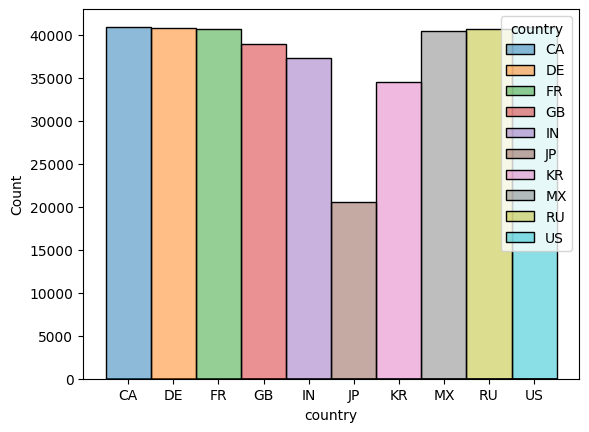

In [57]:
sns.histplot(df_whole, x='country', hue='country')

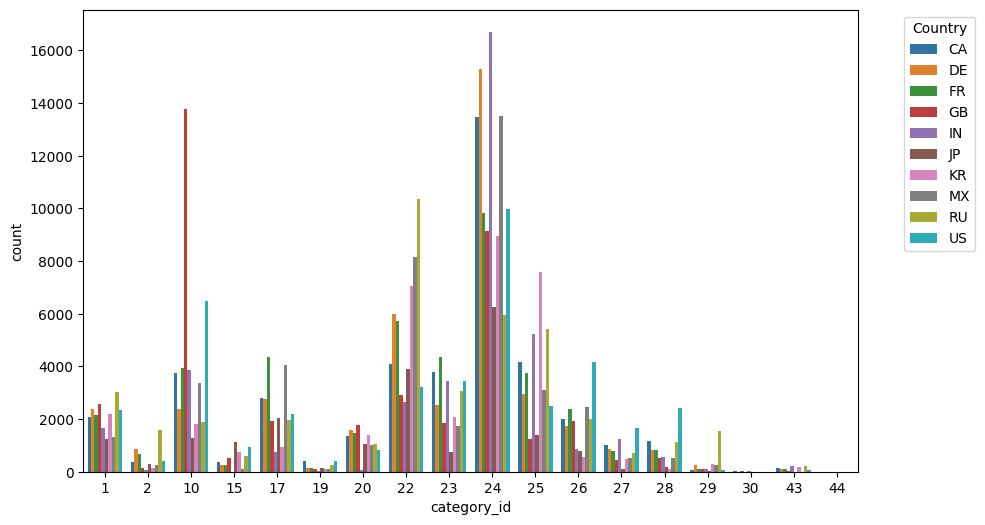

In [58]:
filt_df = df_whole[['category_id', 'likes', 'dislikes', 'views', 'country']]

plt.figure(figsize=(10, 6))
sns.countplot(filt_df, x='category_id', hue='country', palette='tab10')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [59]:
n = df_whole.sort_values("trending_timestamp").groupby(["category_name"])

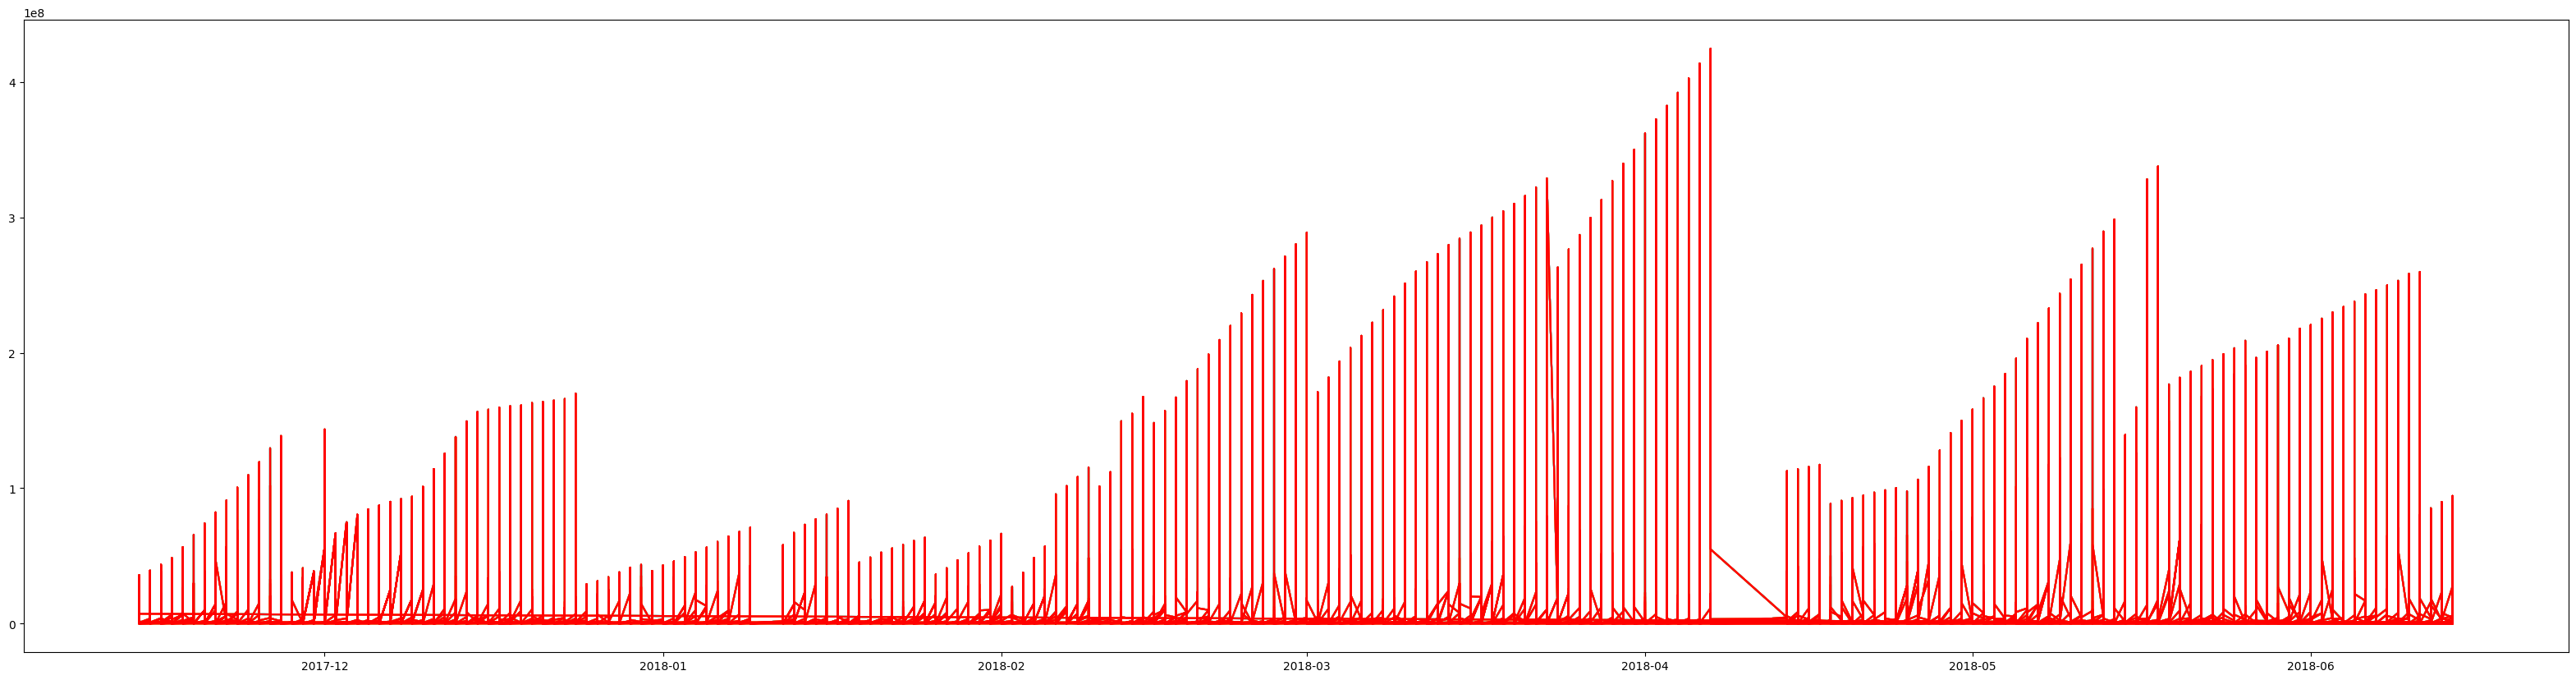

In [60]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    plt.plot(df_whole["trending_timestamp"], df_whole["views"], label=key, color=color)

plt.show()

<Axes: xlabel='category_name', ylabel='views'>

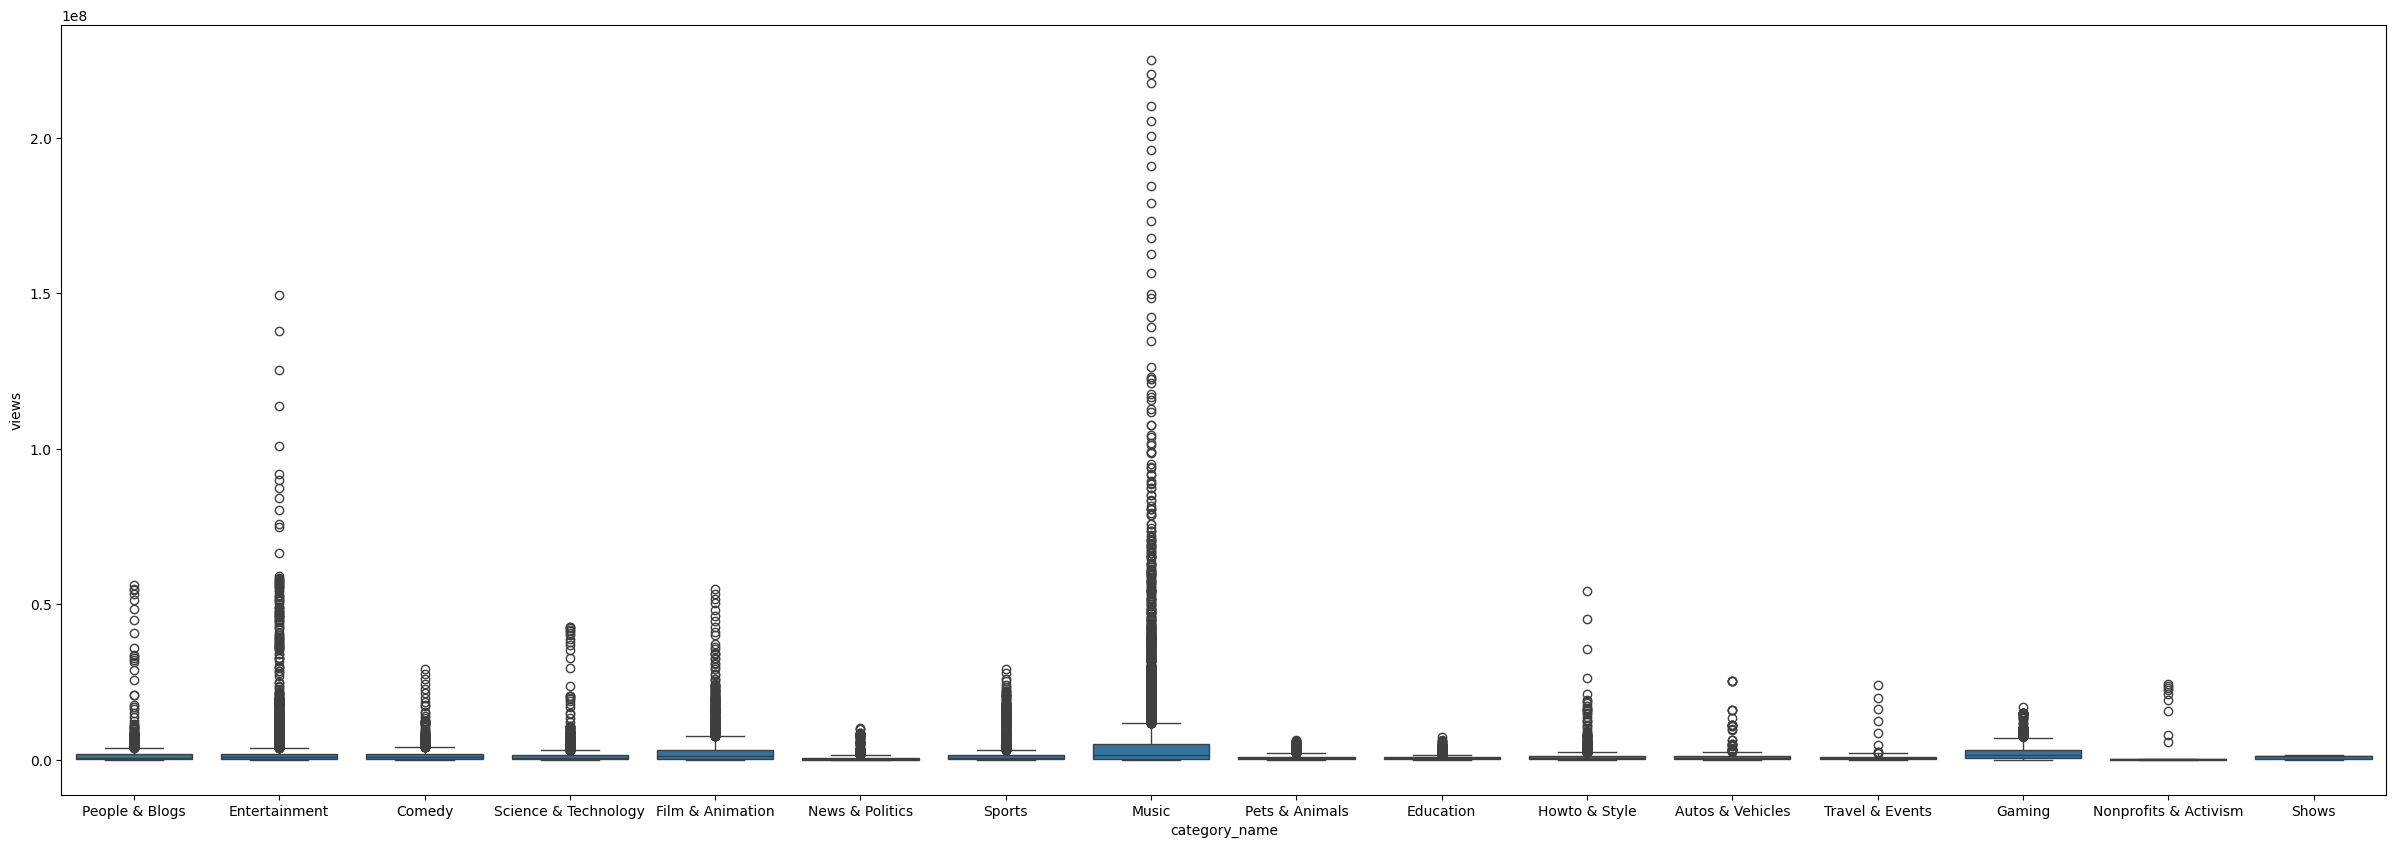

In [61]:
us_filter = df_whole.loc[df_whole['country'] == 'US']

fig, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(x="category_name", y="views", data=us_filter, ax=ax)

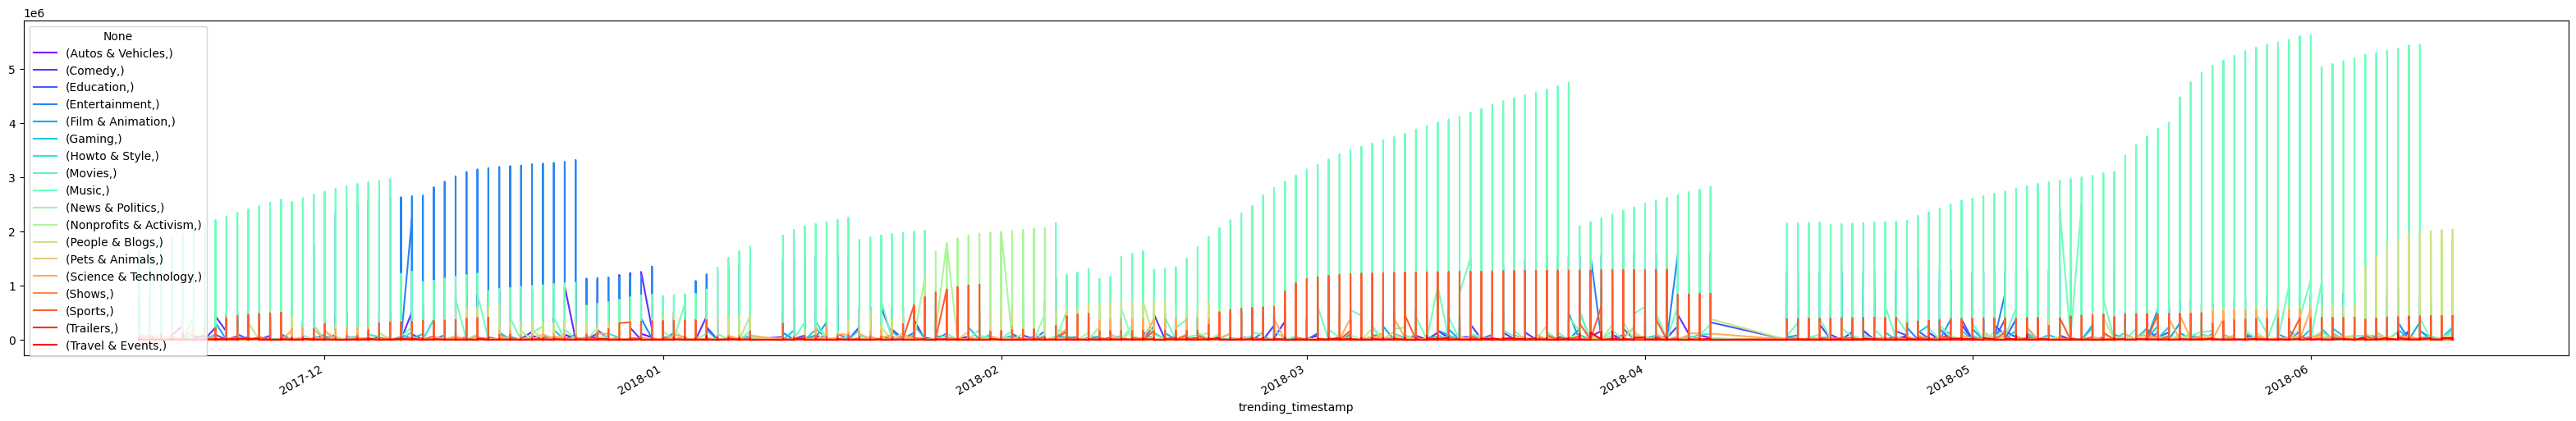

In [62]:
fig, ax = plt.subplots(figsize=(40, 6))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    group.plot(ax=ax, x="trending_timestamp", y="likes", label=key, color=color)

plt.show()

<Axes: xlabel='category_name', ylabel='likes'>

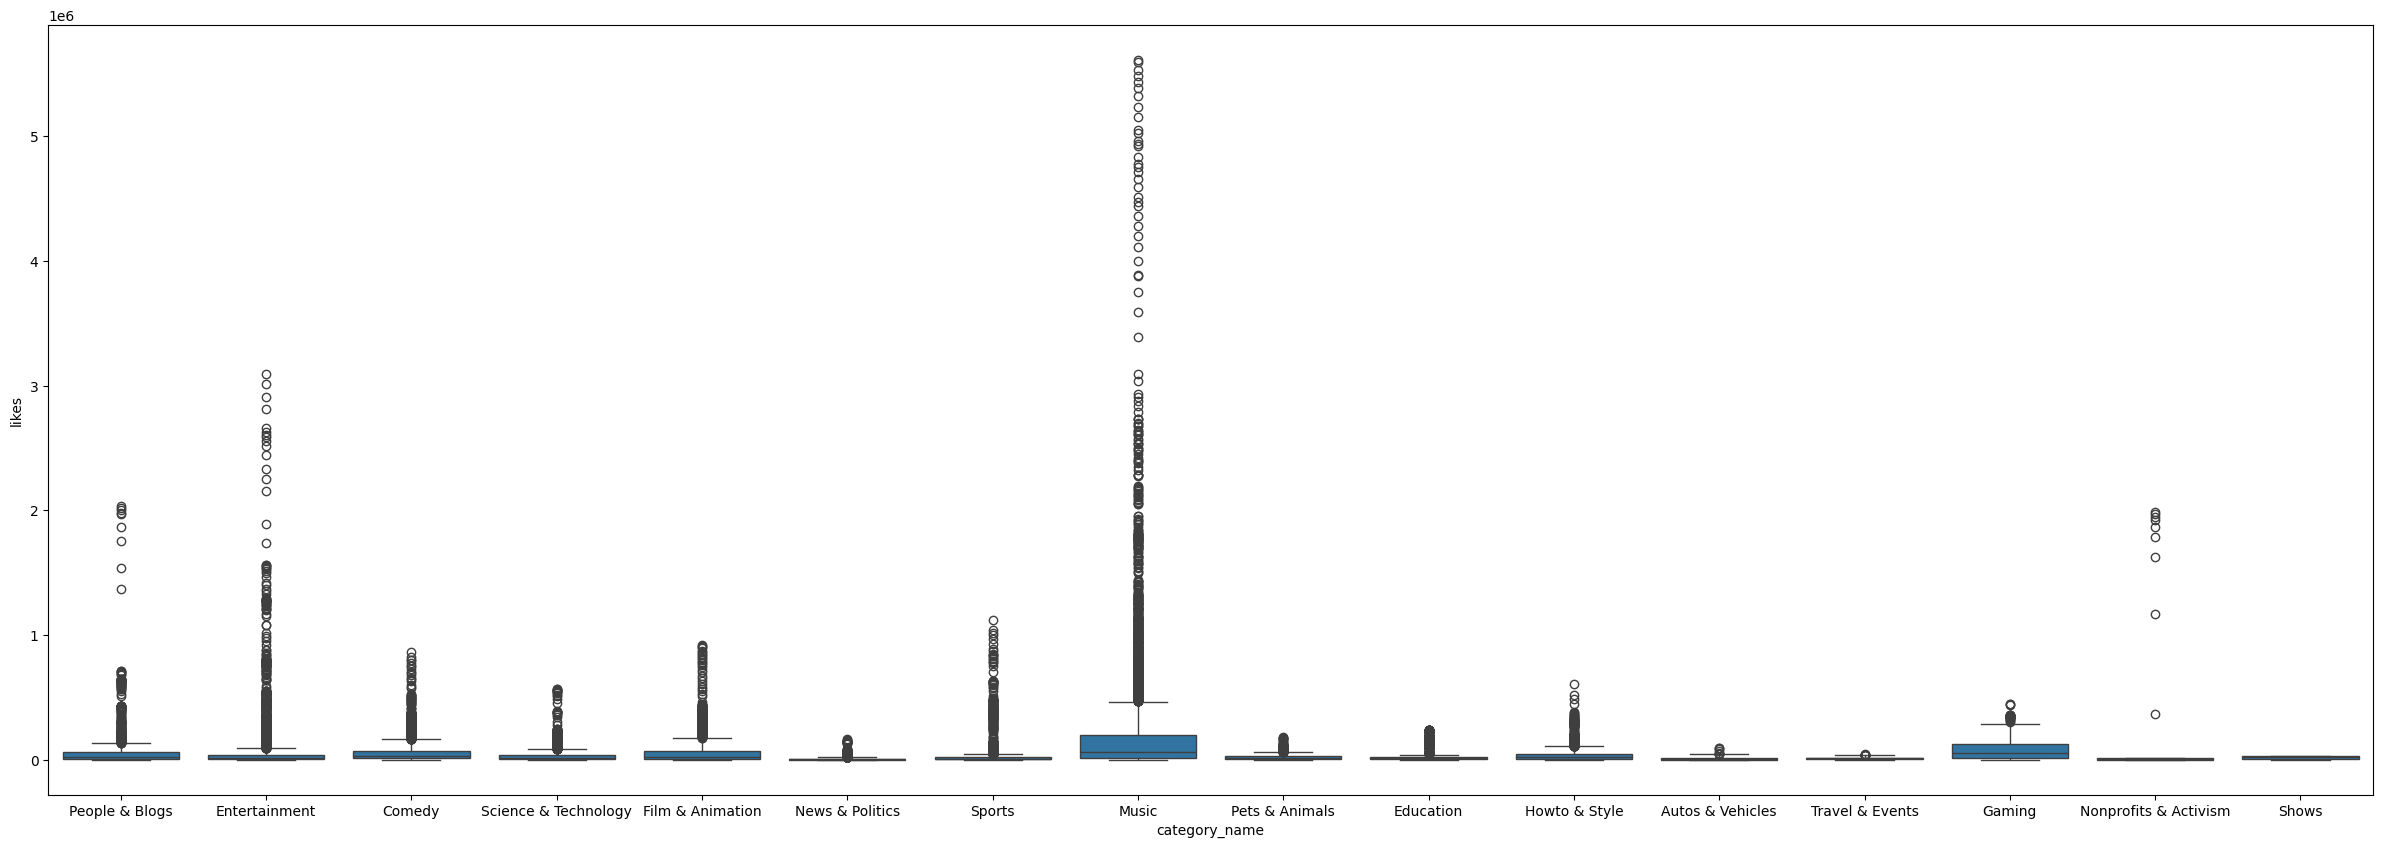

In [63]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(x="category_name", y="likes", data=us_filter, ax=ax)

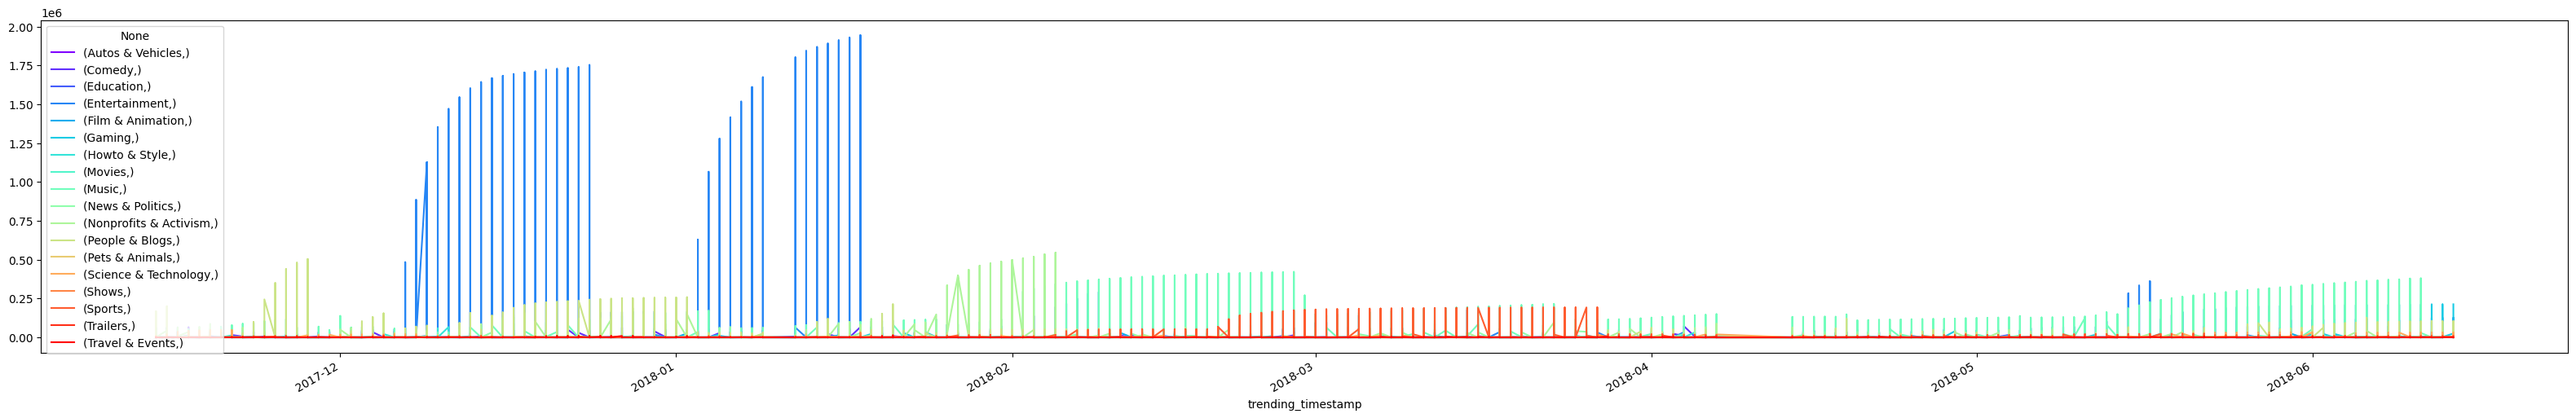

In [64]:
fig, ax = plt.subplots(figsize=(40, 6))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    group.plot(ax=ax, x="trending_timestamp", y="dislikes", label=key, color=color)

plt.show()

<Axes: xlabel='category_name', ylabel='dislikes'>

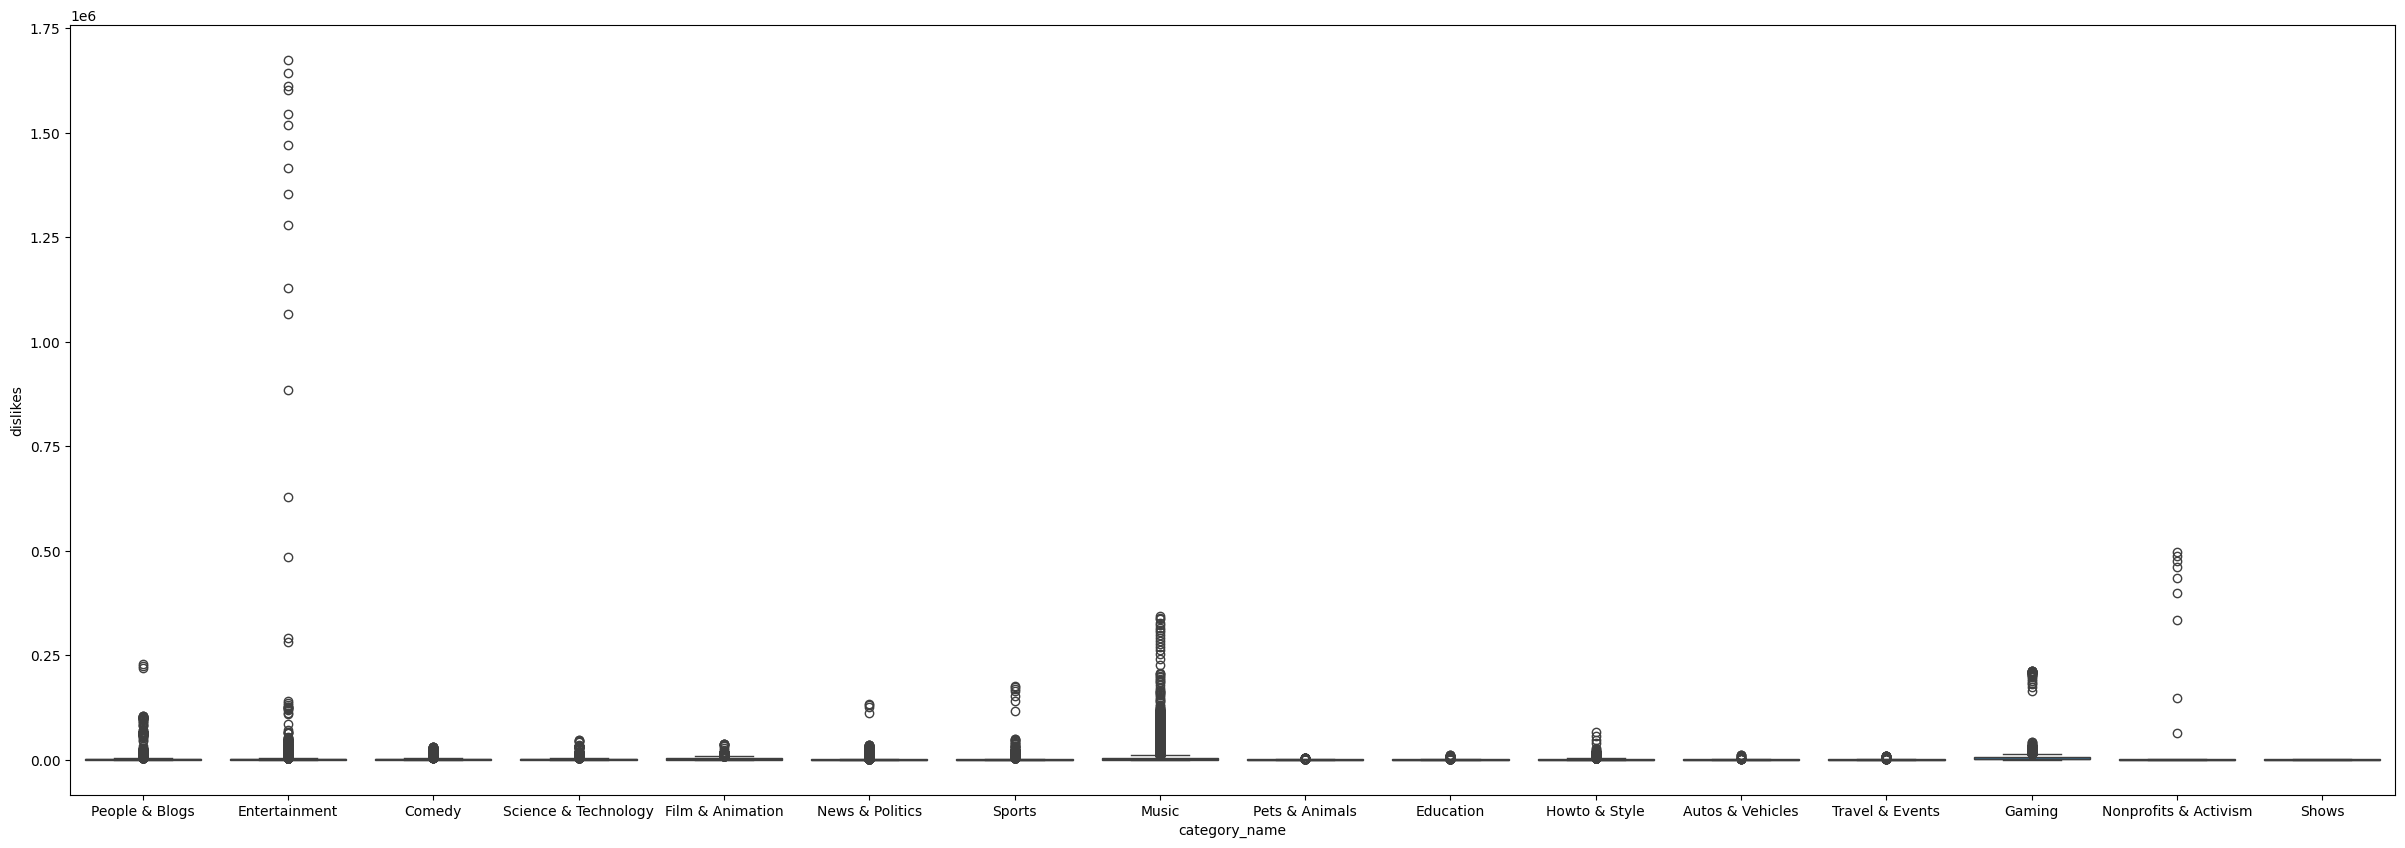

In [65]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(x="category_name", y="dislikes", data=us_filter, ax=ax)

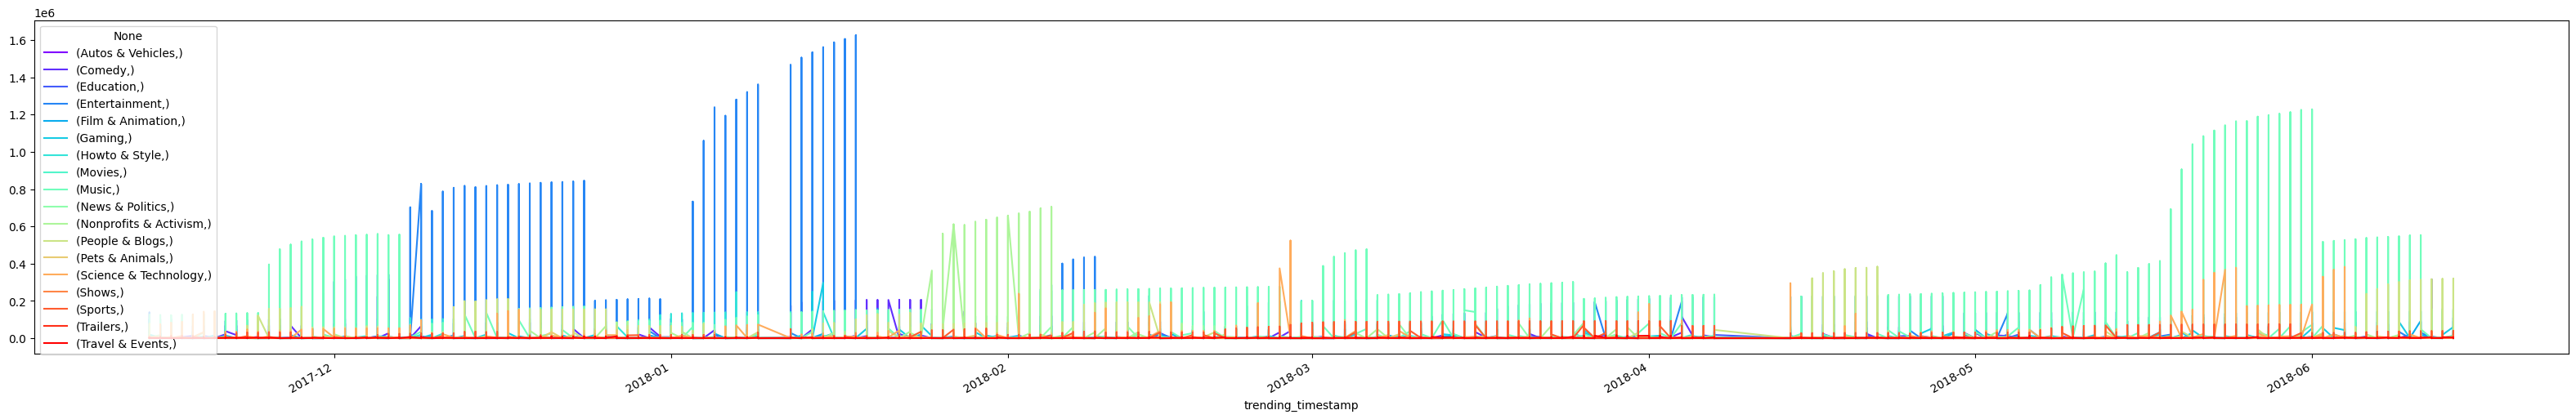

In [66]:
fig, ax = plt.subplots(figsize=(40, 6))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    group.plot(ax=ax, x="trending_timestamp", y="comment_count", label=key, color=color)

plt.show()

<Axes: xlabel='category_name', ylabel='comment_count'>

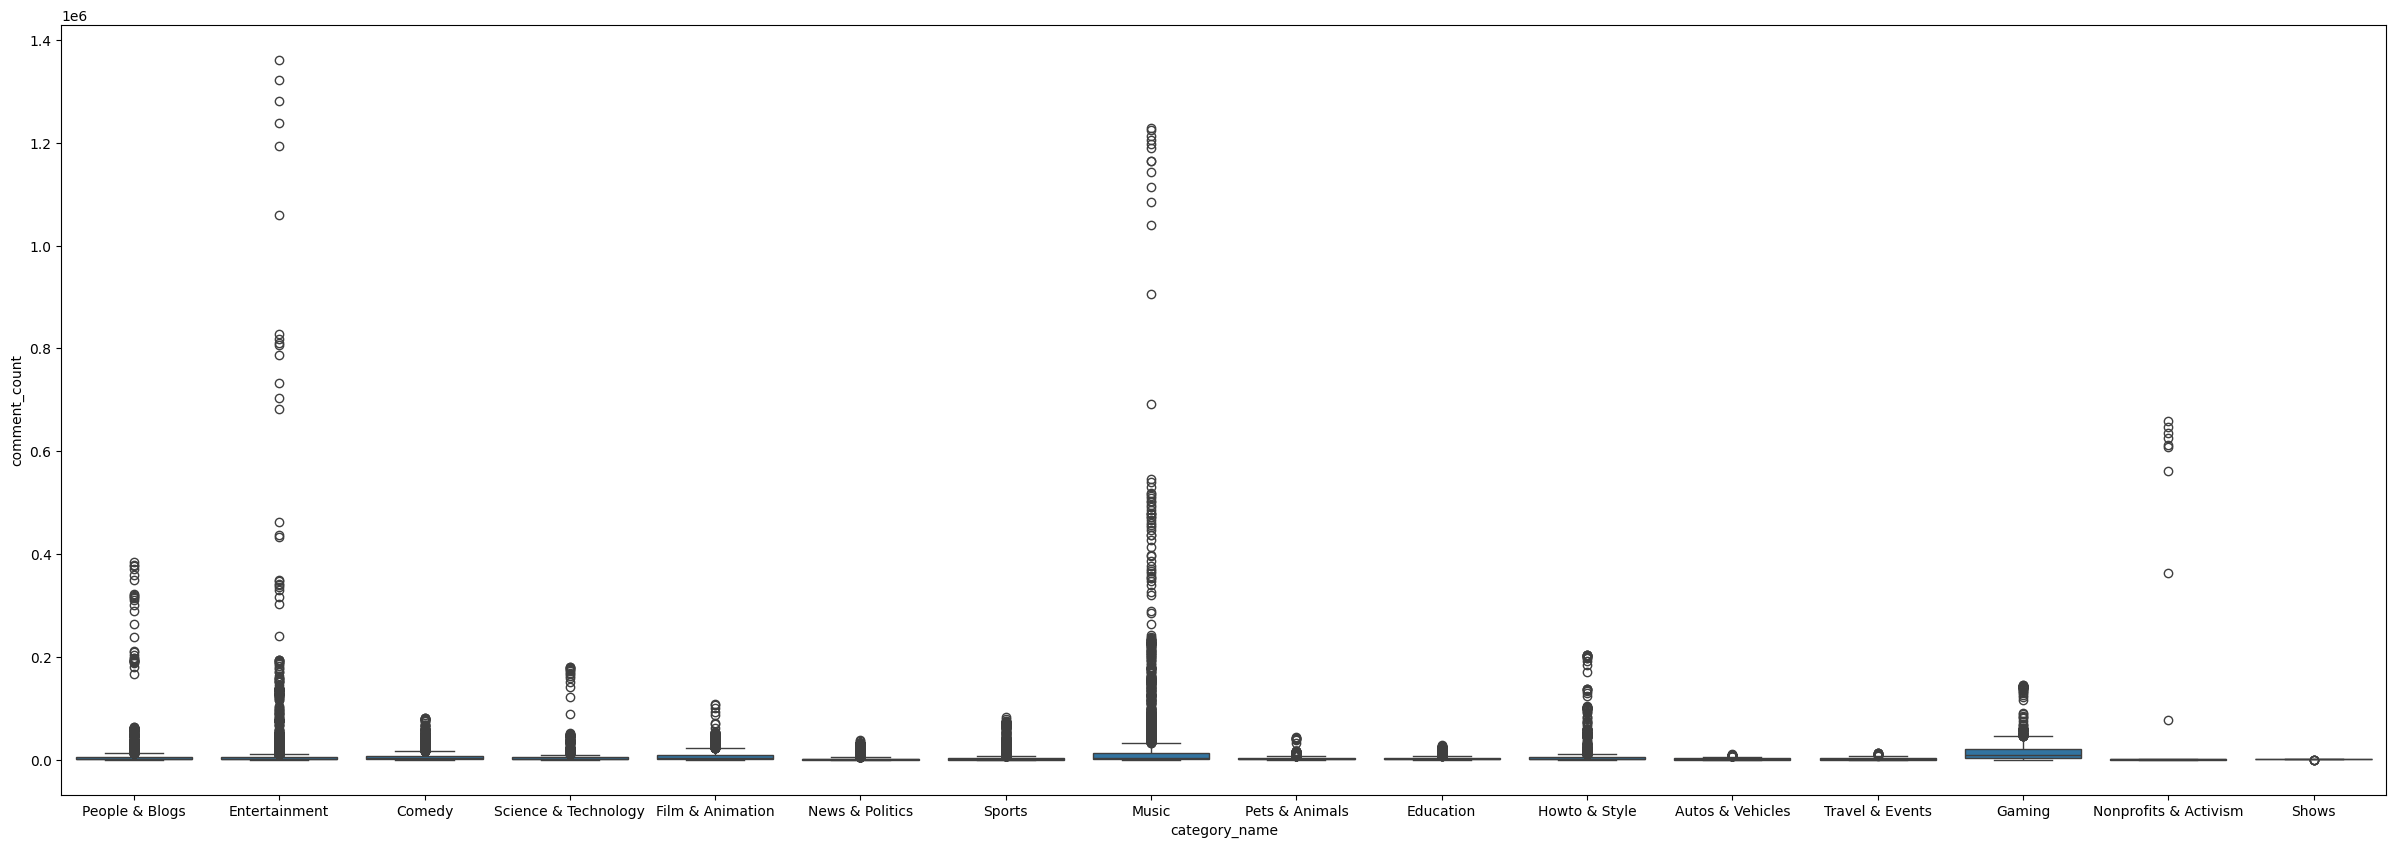

In [67]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(x="category_name", y="comment_count", data=us_filter, ax=ax)

**India EDA**
- category_id vs. views
- trending_date vs. views

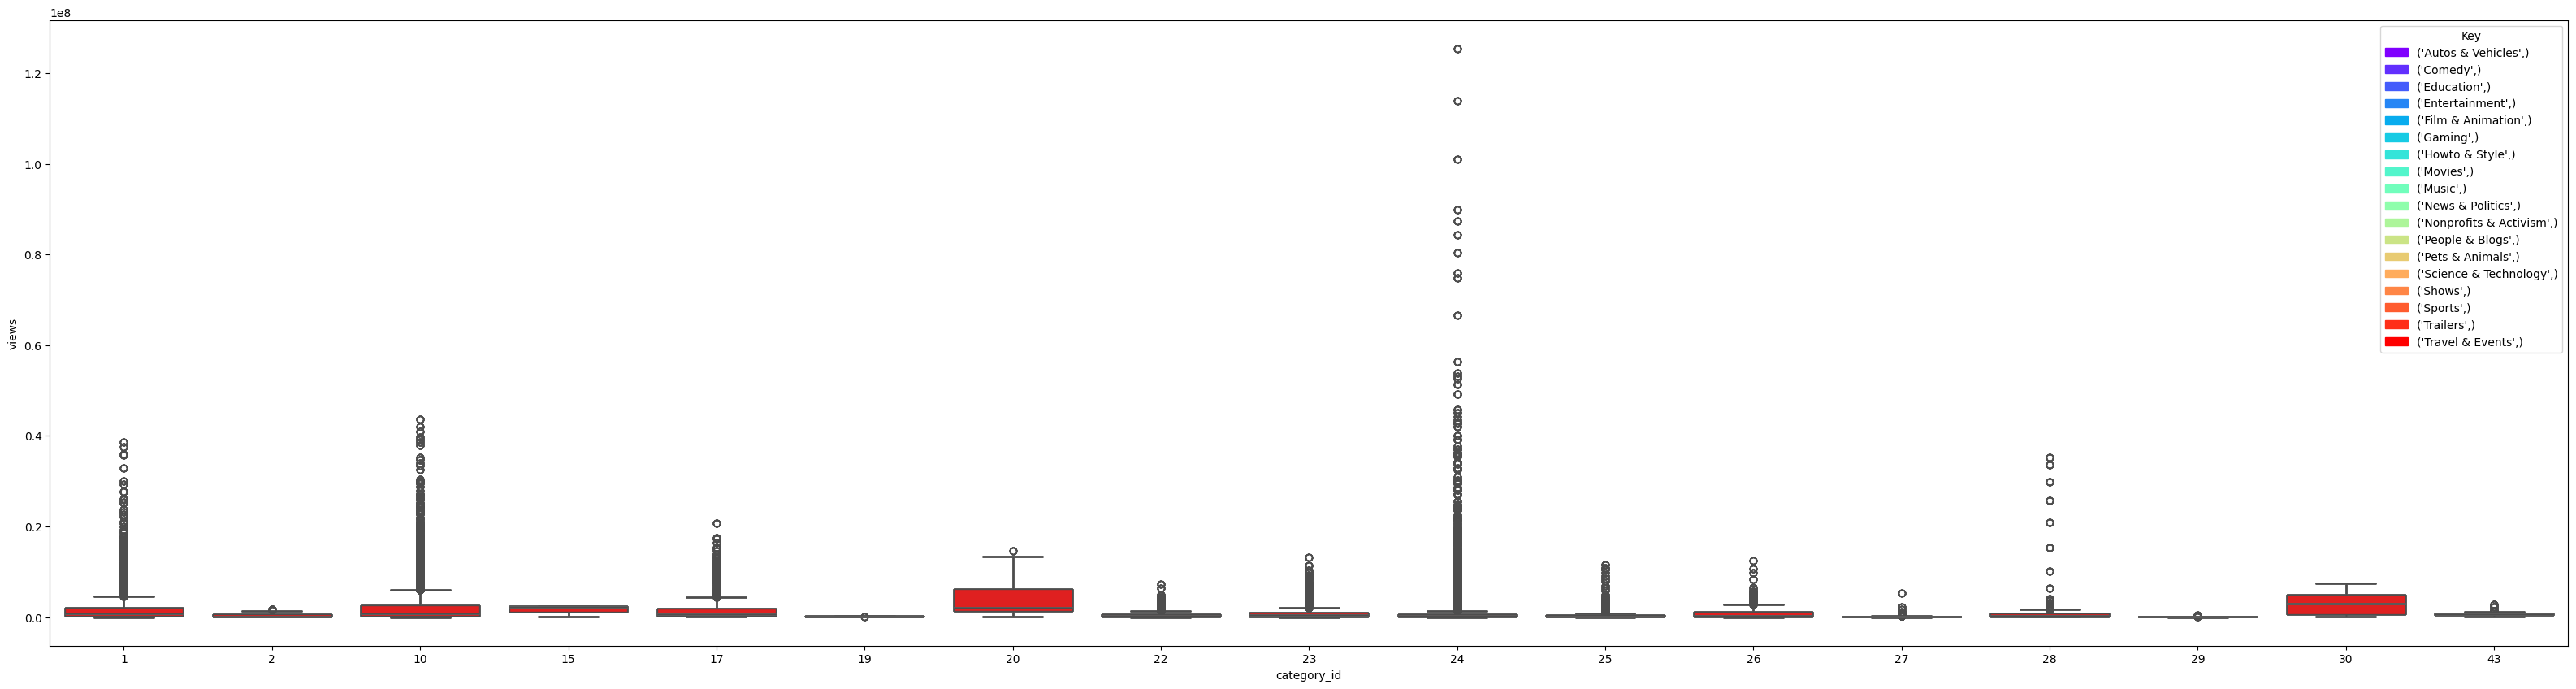

In [68]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    sns.boxplot(x="category_id", y="views", data=df_in, color=color)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = [key for key, _ in n]
plt.legend(handles, labels, title='Key')

plt.show()

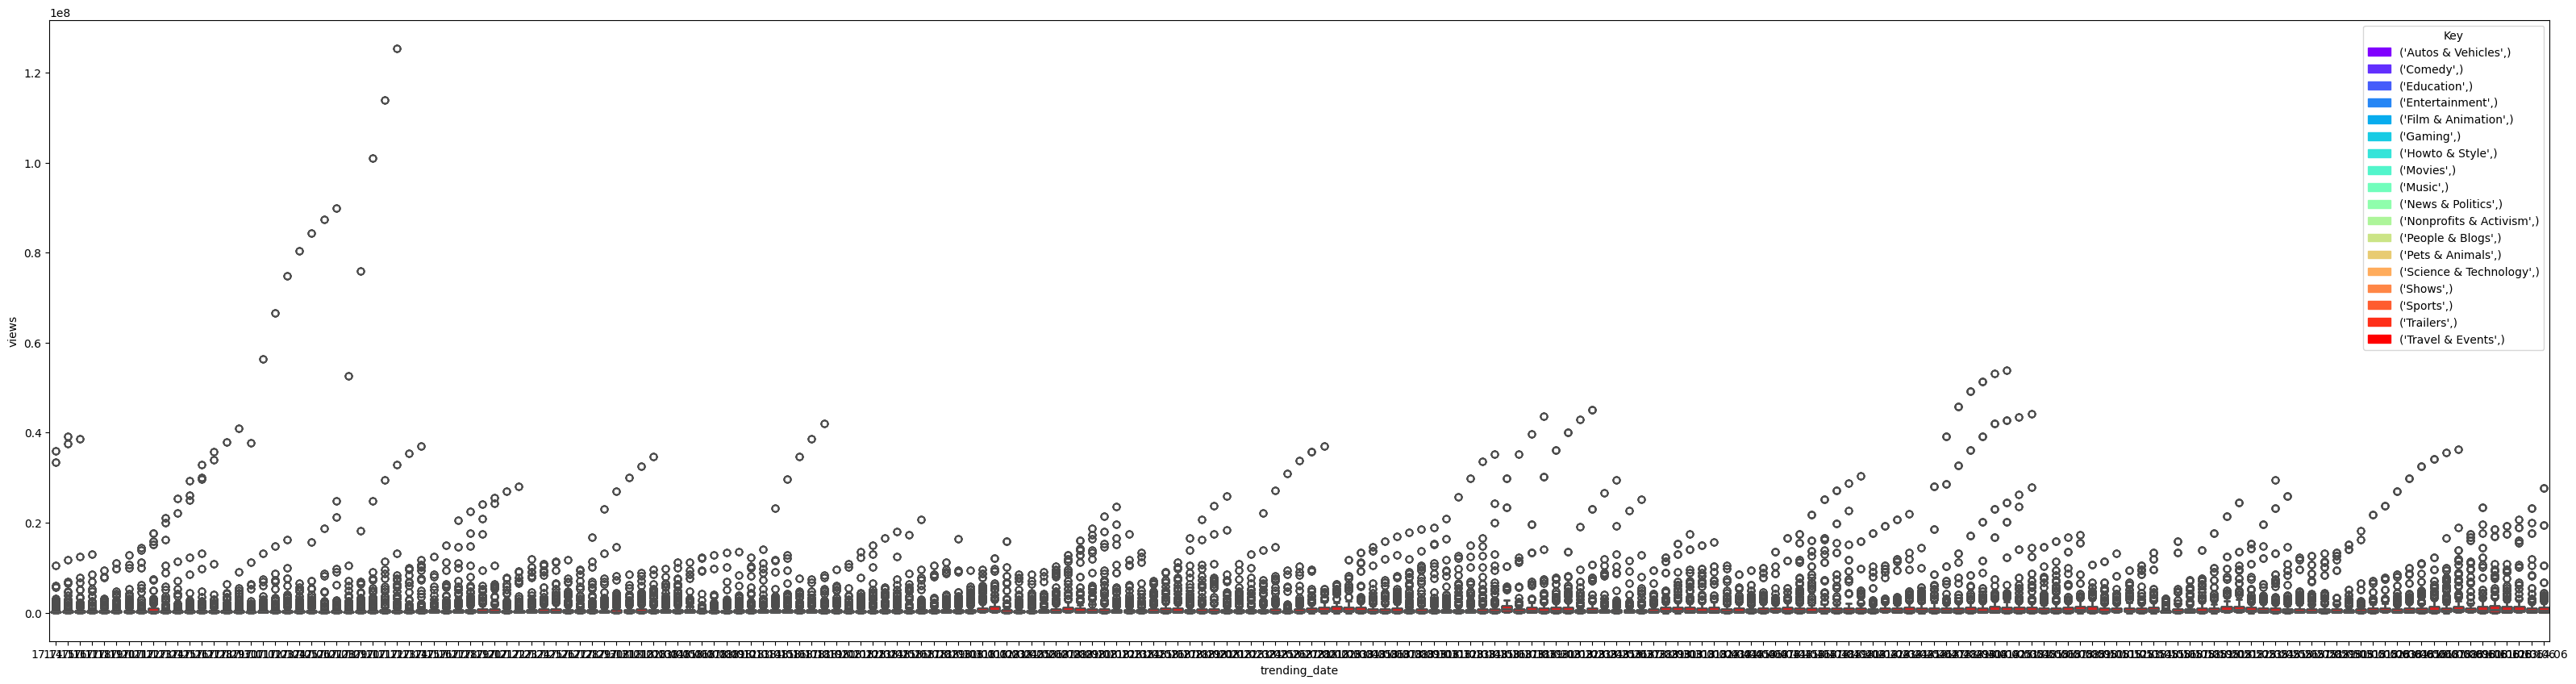

In [69]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    sns.boxplot(x="trending_date", y="views", data=df_in, color=color)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = [key for key, _ in n]
plt.legend(handles, labels, title='Key')

plt.show()

**Great Britain EDA**
- category_id vs. views
- trending_date vs. views

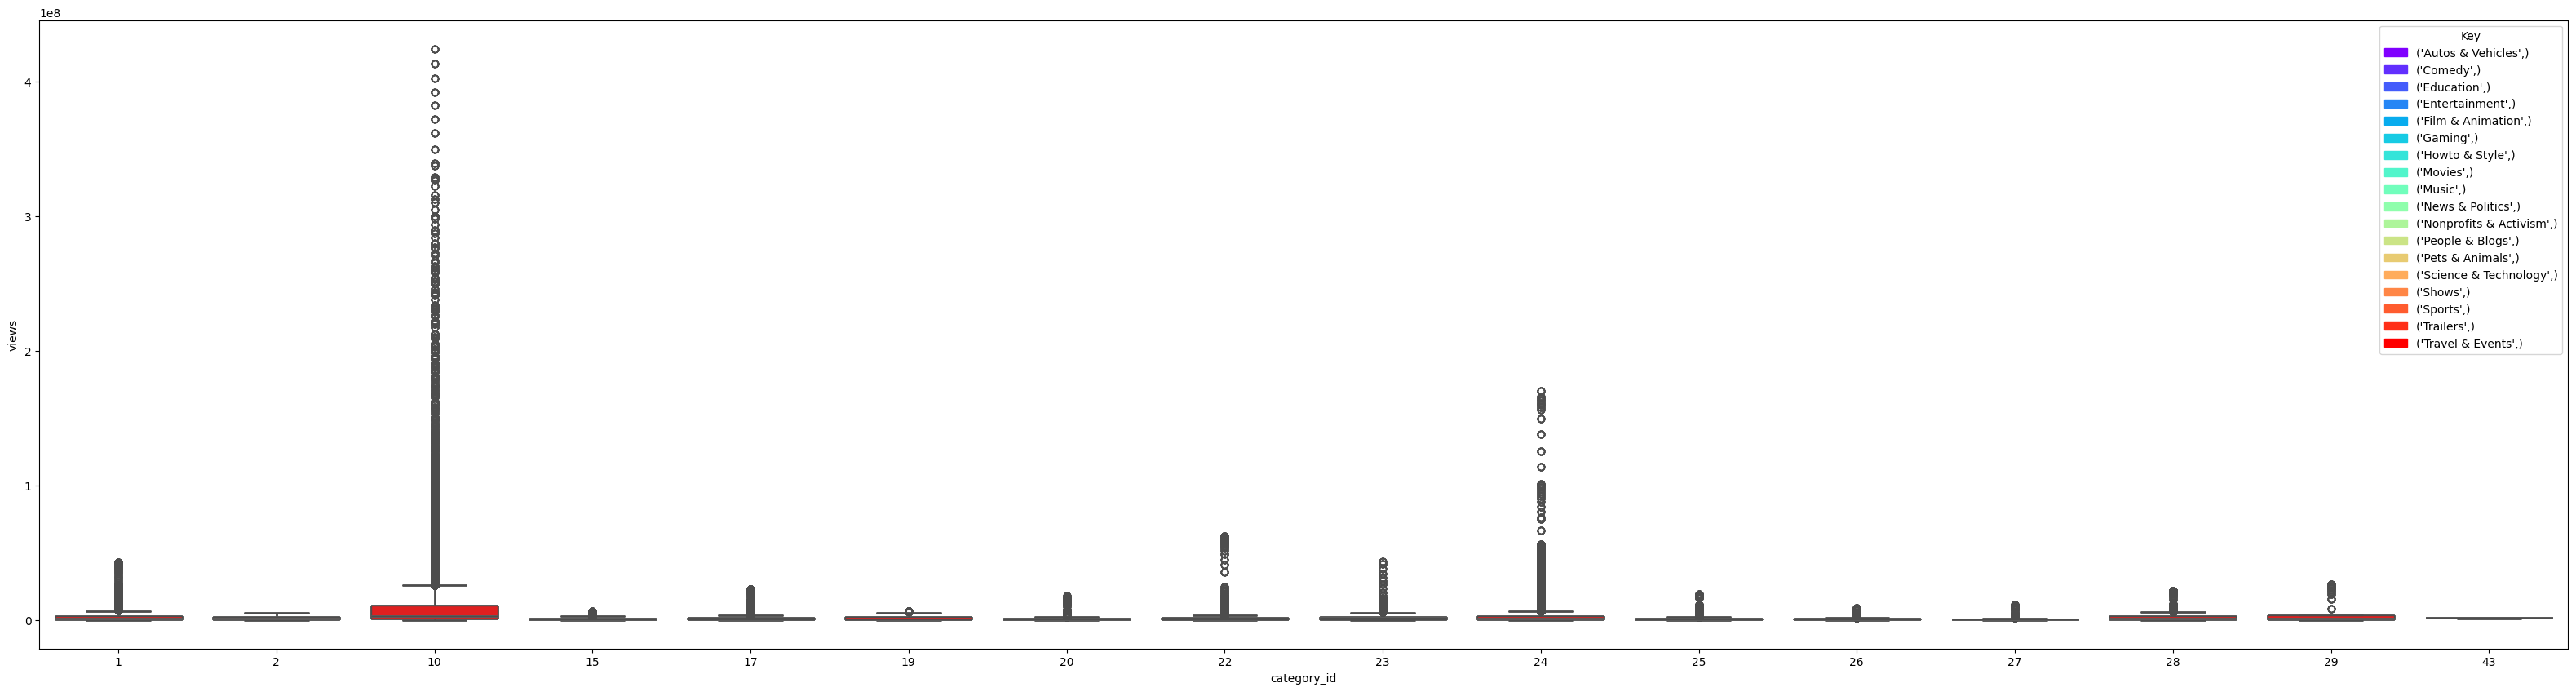

In [70]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    sns.boxplot(x="category_id", y="views", data=df_gb, color=color)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = [key for key, _ in n]
plt.legend(handles, labels, title='Key')

plt.show()

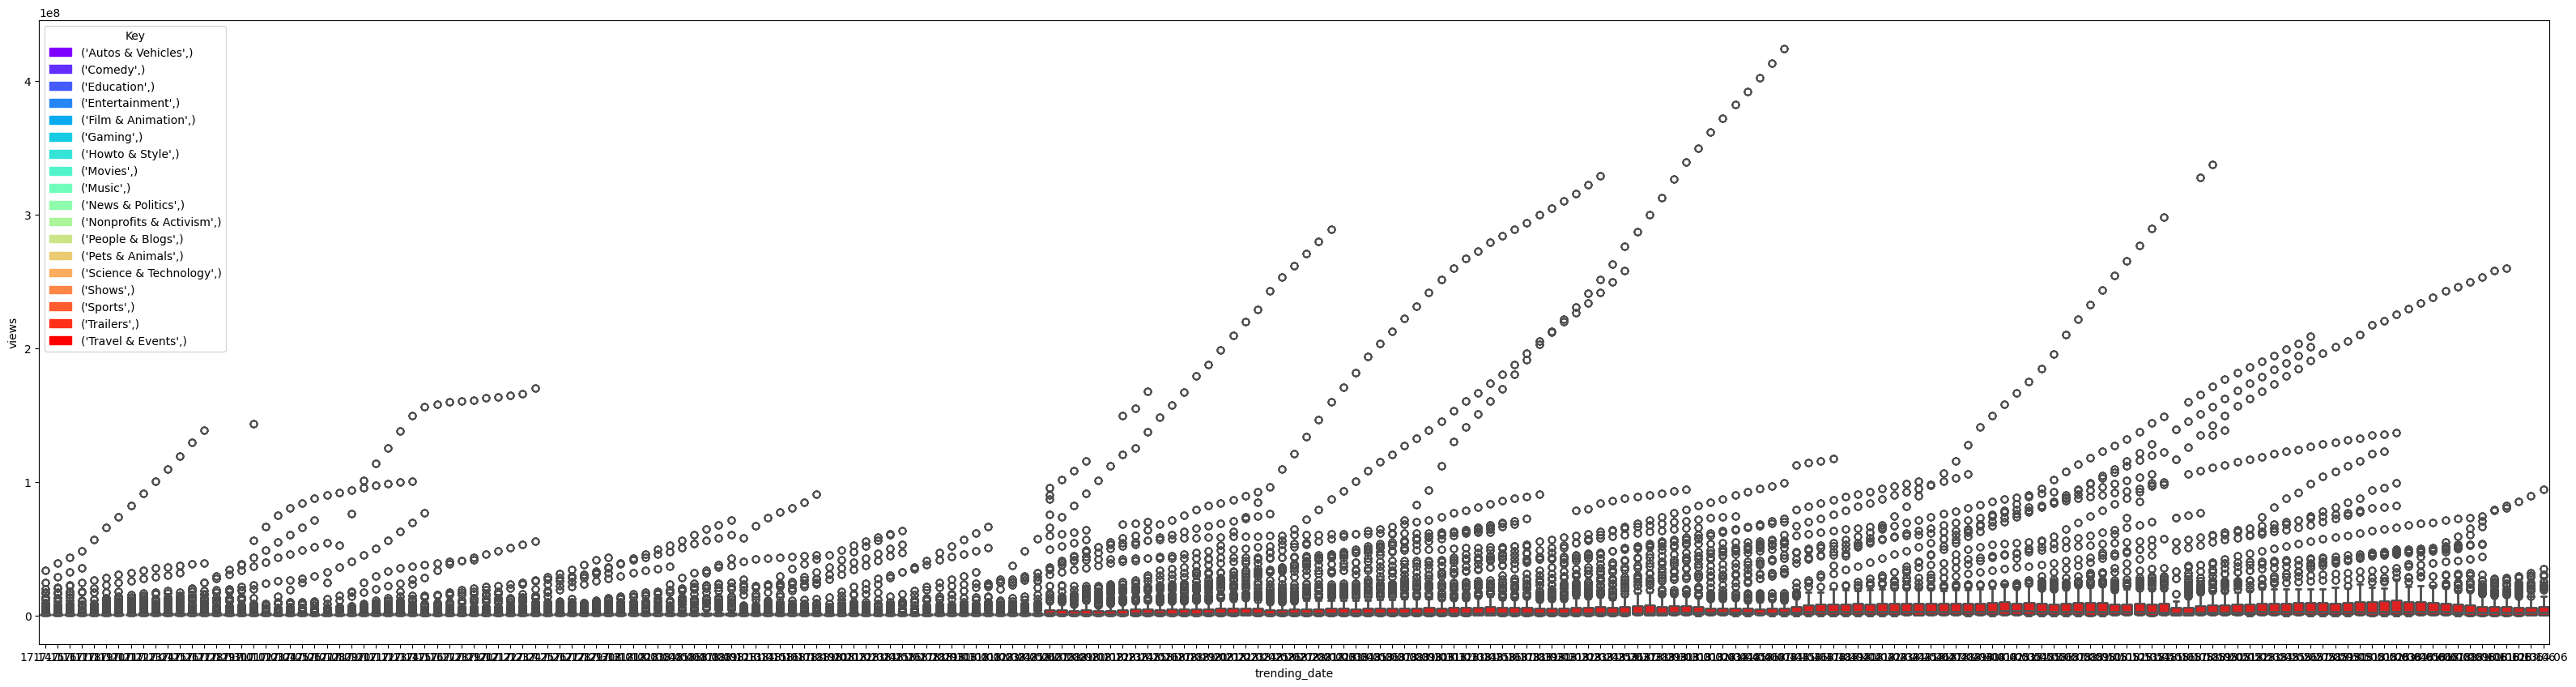

In [71]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    sns.boxplot(x="trending_date", y="views", data=df_gb, color=color)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = [key for key, _ in n]
plt.legend(handles, labels, title='Key')

plt.show()

**France EDA**
- category_id vs. views
- trending_date vs. views

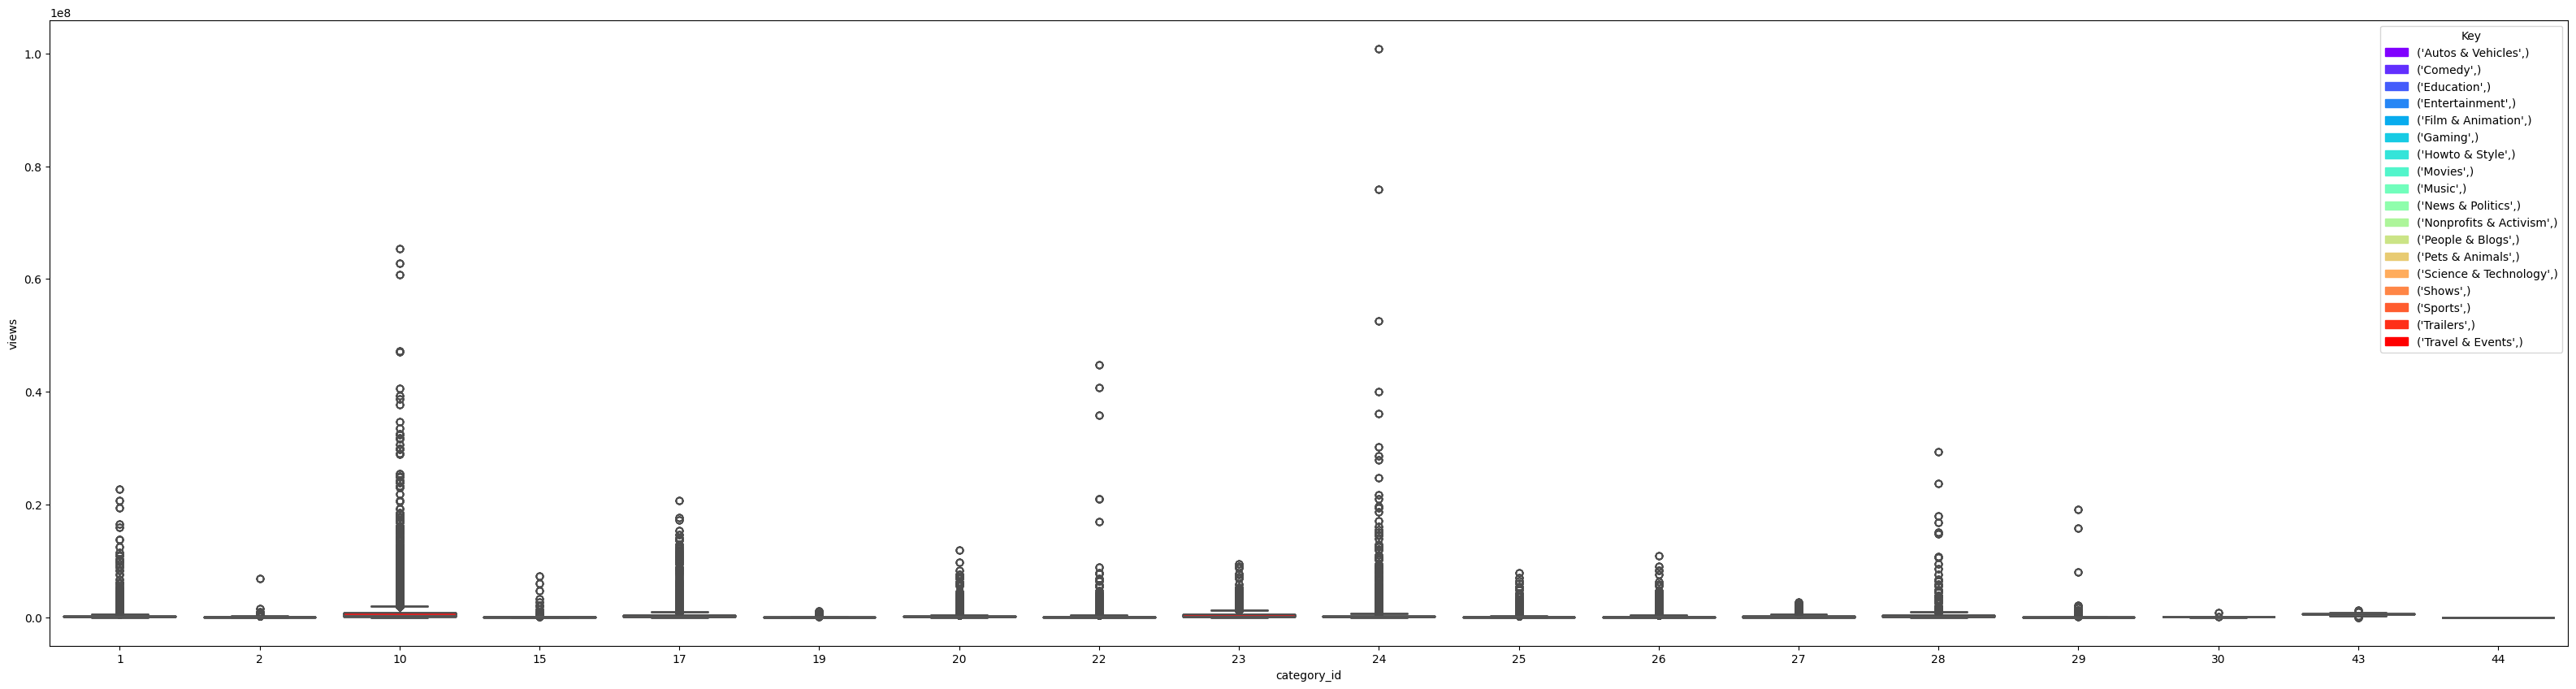

In [72]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    sns.boxplot(x="category_id", y="views", data=df_fr, color=color)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = [key for key, _ in n]
plt.legend(handles, labels, title='Key')

plt.show()

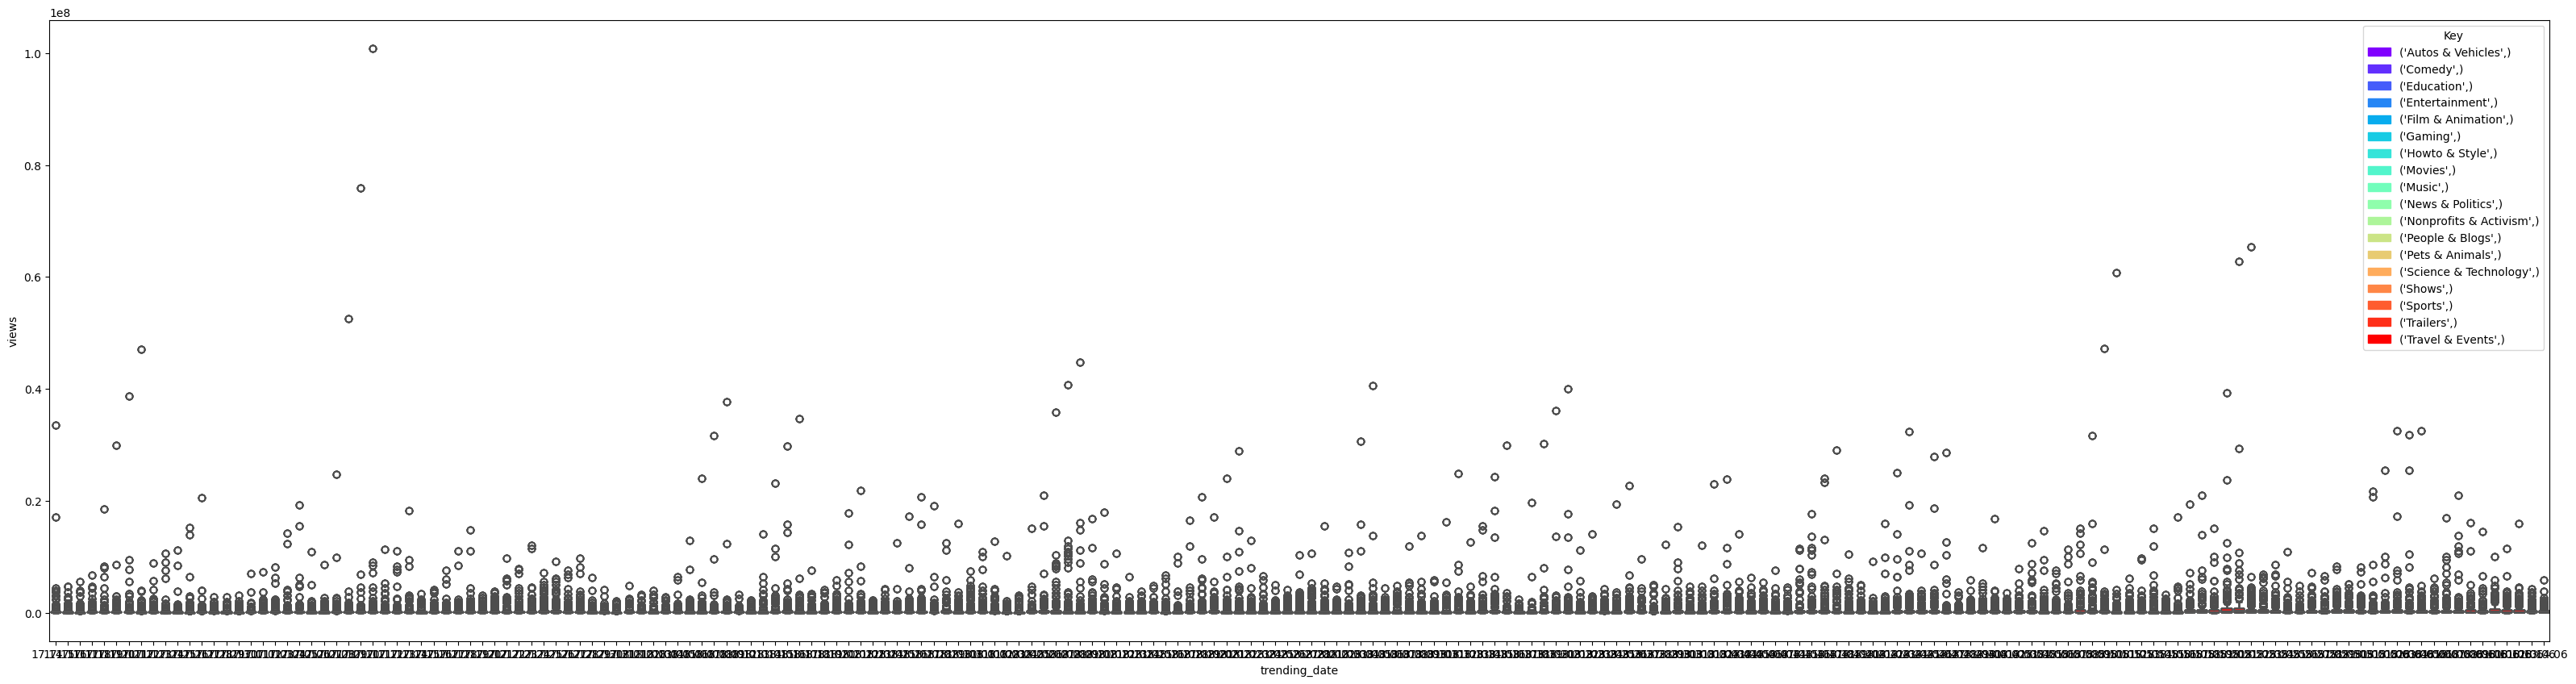

In [73]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    sns.boxplot(x="trending_date", y="views", data=df_fr, color=color)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = [key for key, _ in n]
plt.legend(handles, labels, title='Key')

plt.show()

**Denmark EDA**
- category_id vs. views
- trending_date vs. views

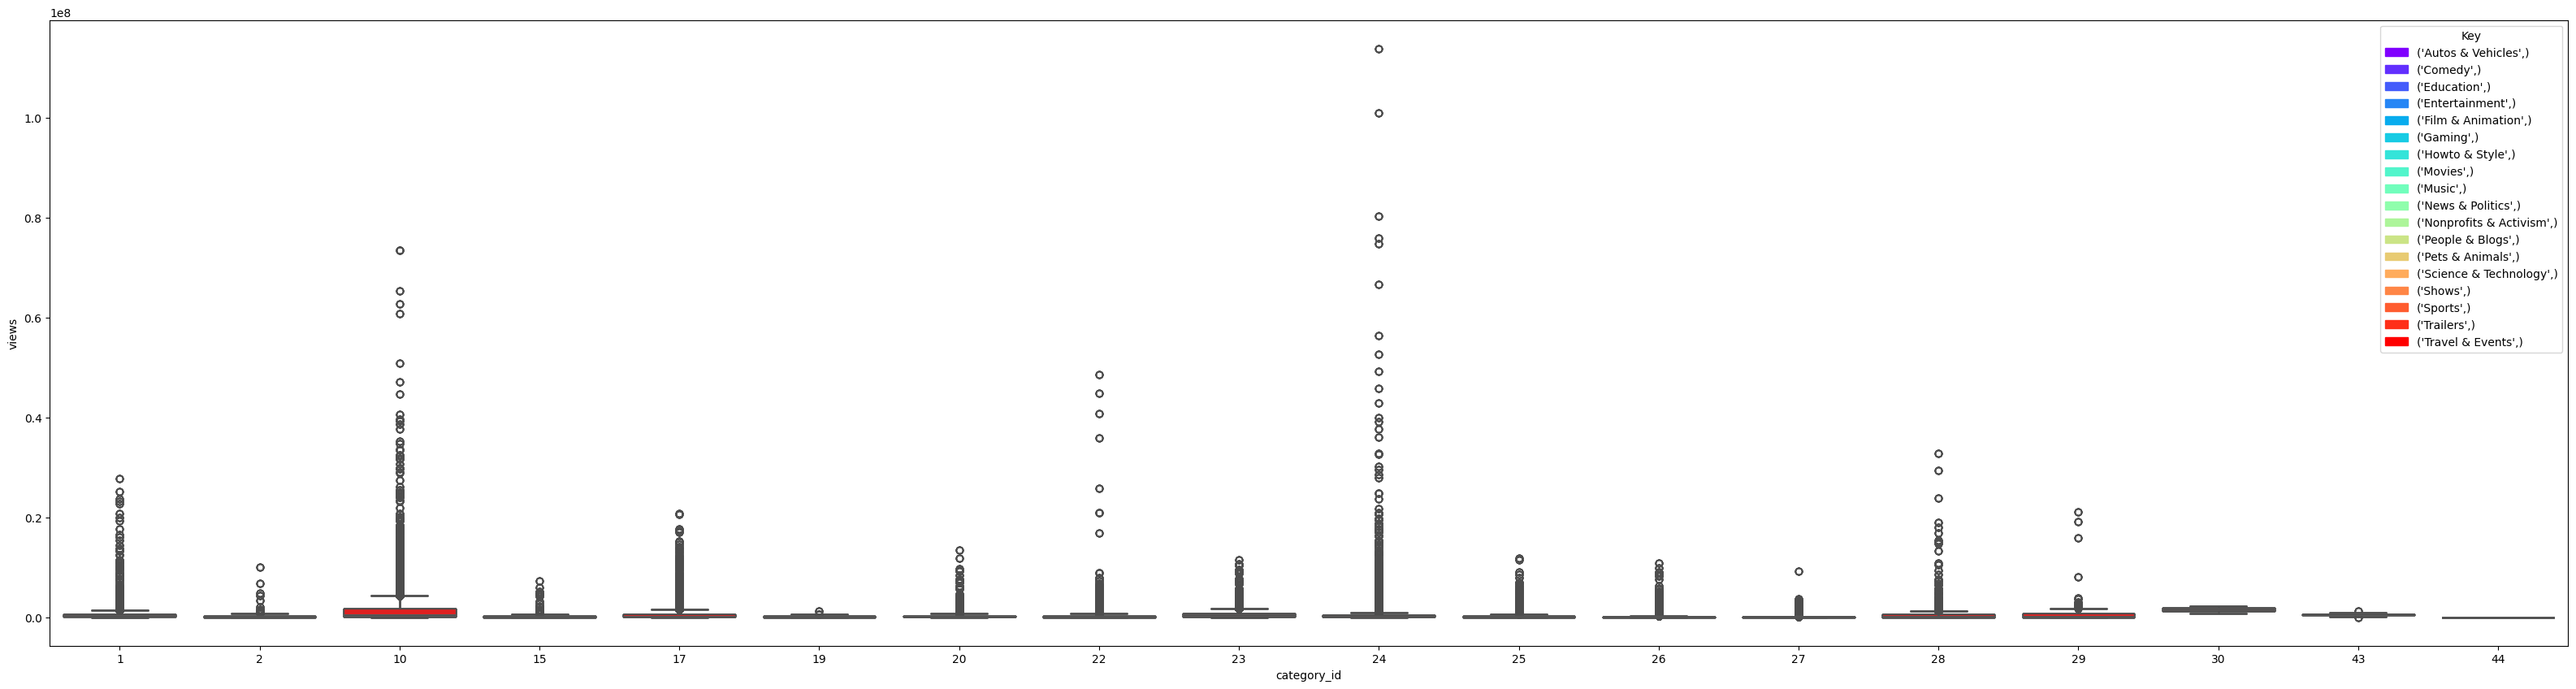

In [74]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    sns.boxplot(x="category_id", y="views", data=df_de, color=color)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = [key for key, _ in n]
plt.legend(handles, labels, title='Key')

plt.show()

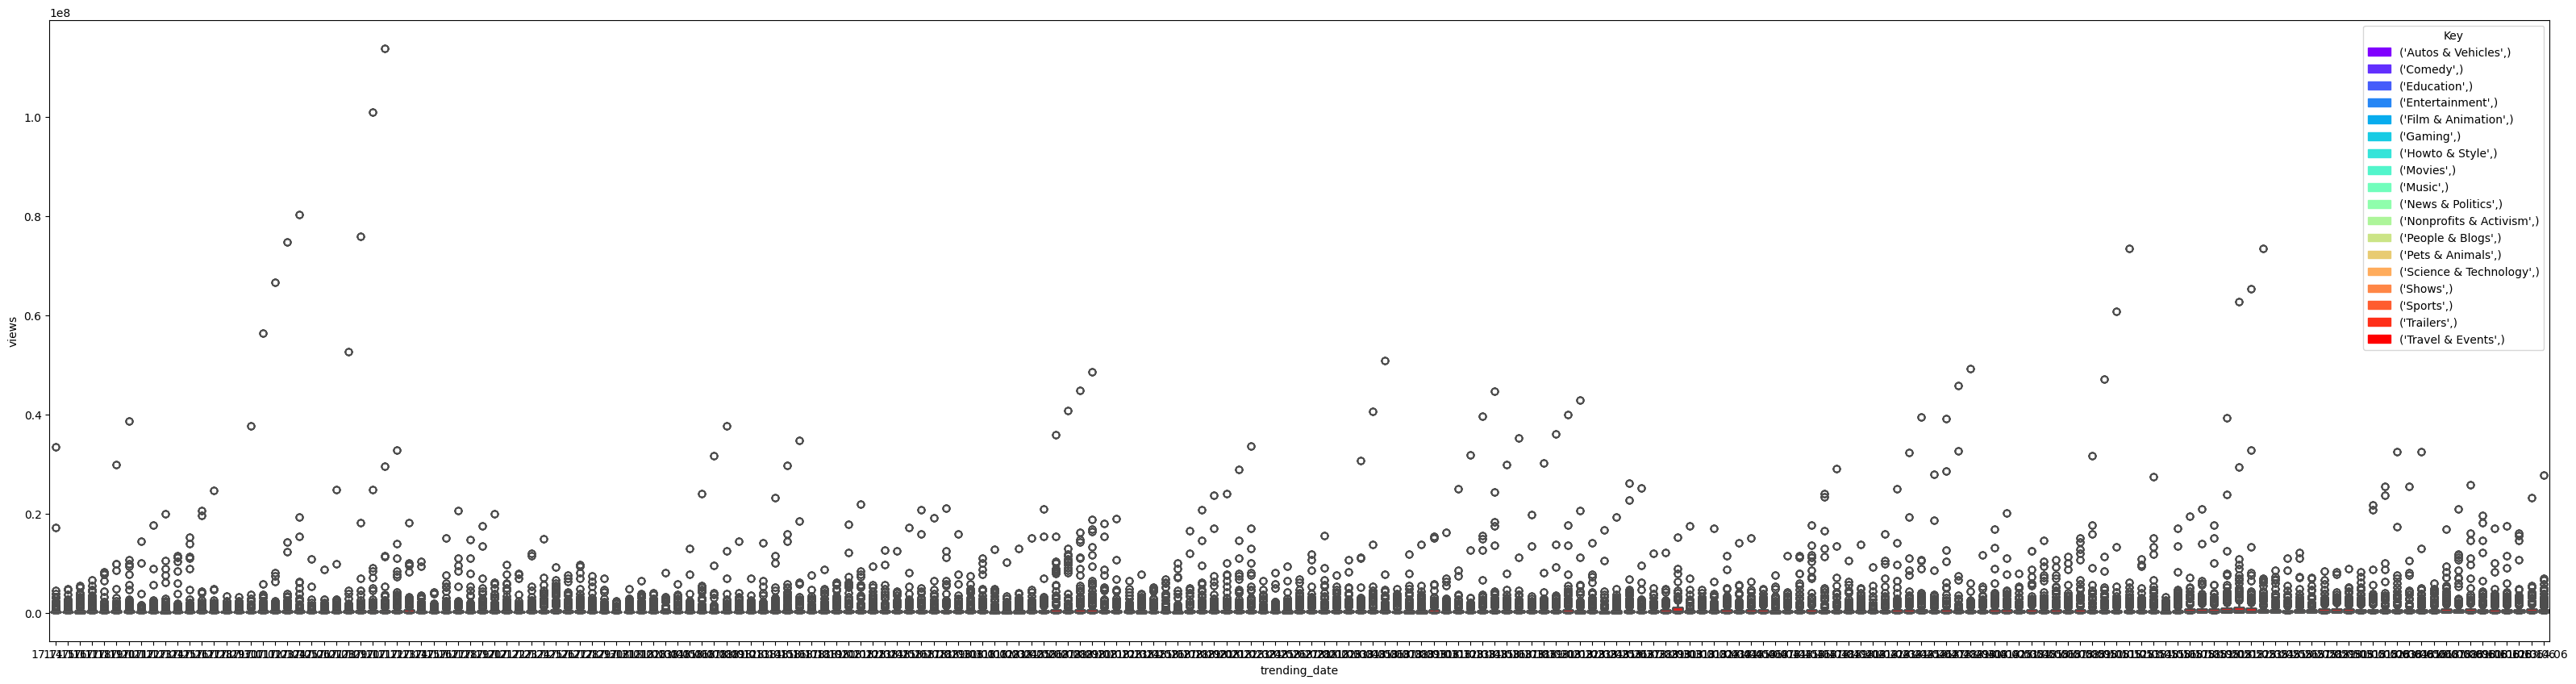

In [75]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    sns.boxplot(x="trending_date", y="views", data=df_de, color=color)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = [key for key, _ in n]
plt.legend(handles, labels, title='Key')

plt.show()

**Canada EDA**
- category_id vs. views
- trending_date vs. views

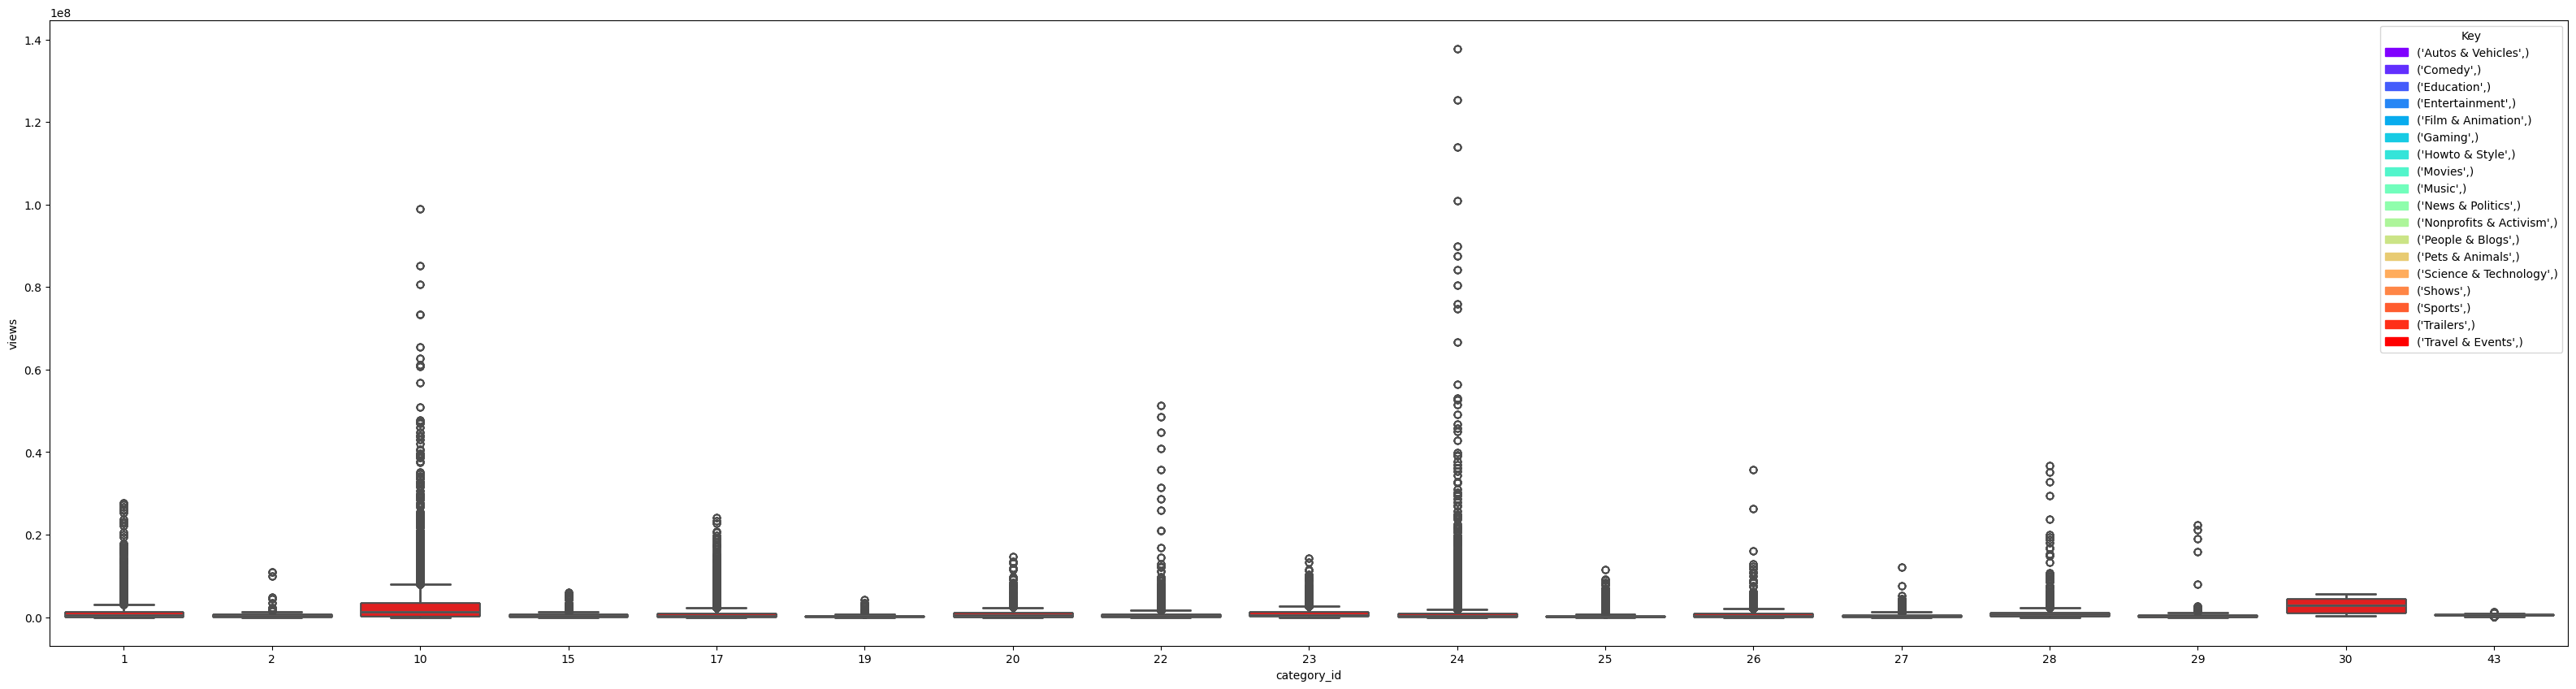

In [76]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    sns.boxplot(x="category_id", y="views", data=df_ca, color=color)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = [key for key, _ in n]
plt.legend(handles, labels, title='Key')

plt.show()

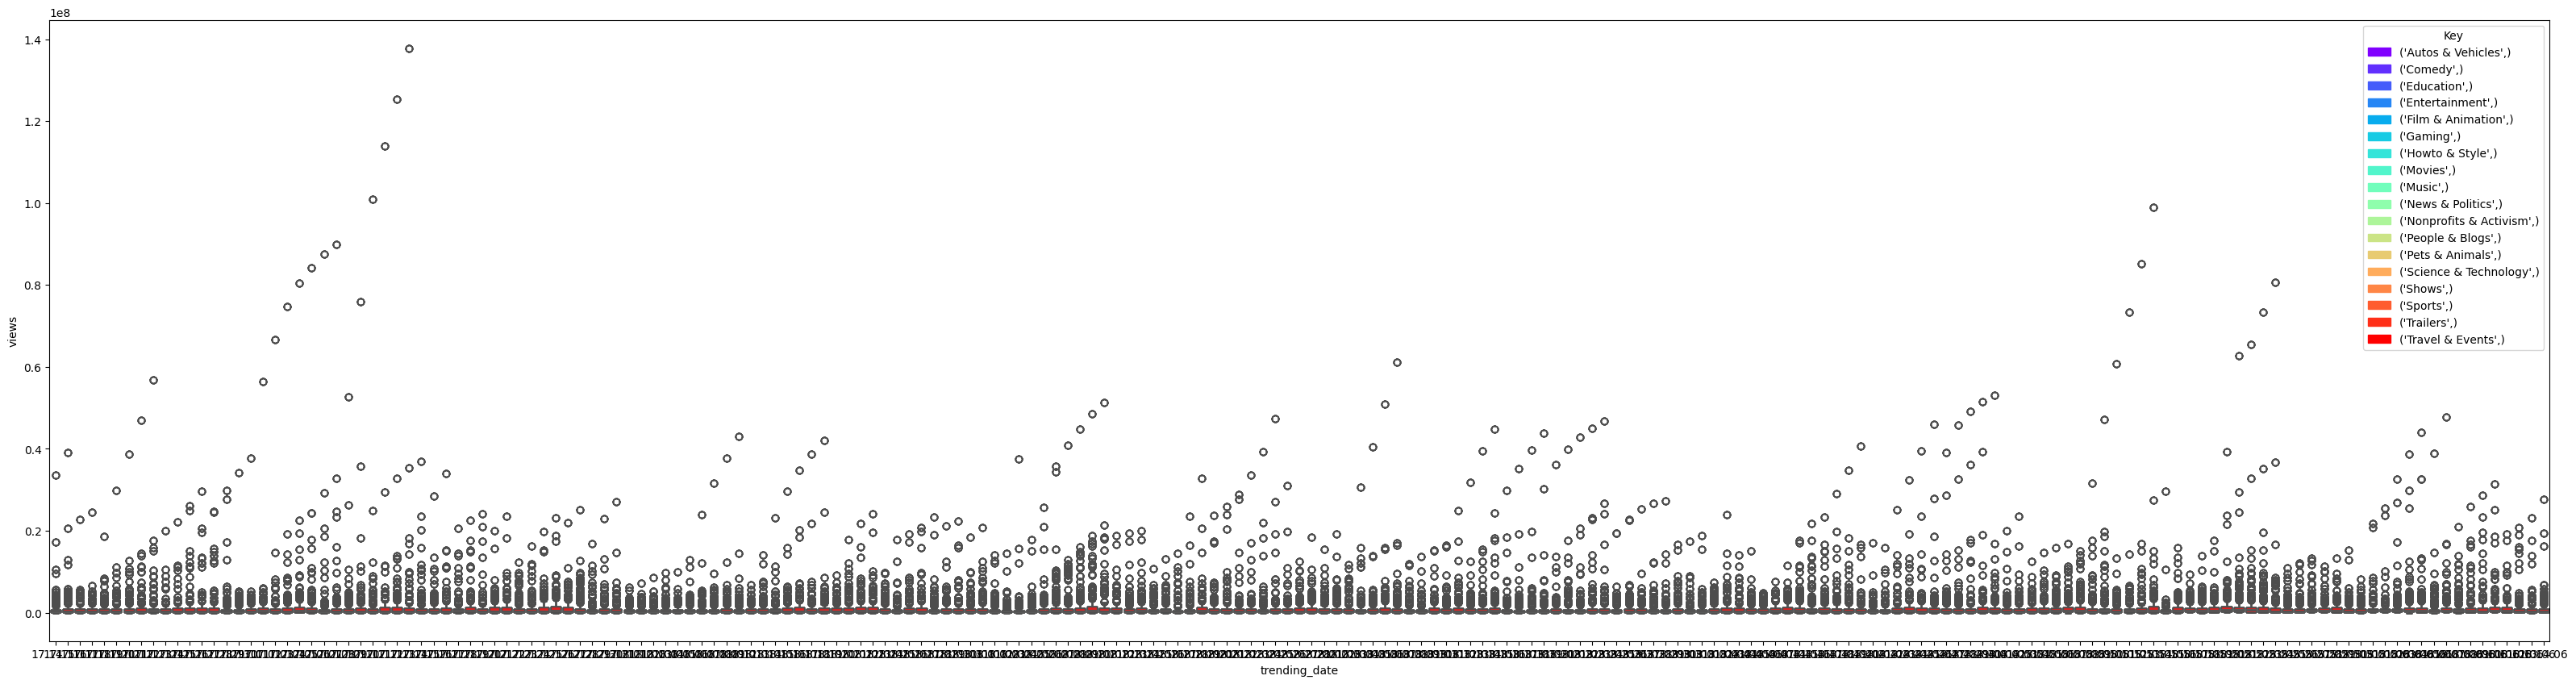

In [77]:
fig, ax = plt.subplots(figsize=(40, 10))
colors = cm.rainbow(np.linspace(0, 1, len(n)))
for (key, group), color in zip(n, colors):
    sns.boxplot(x="trending_date", y="views", data=df_ca, color=color)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = [key for key, _ in n]
plt.legend(handles, labels, title='Key')

plt.show()

### Hypothesis Test

**$H_0$**: There is no significant difference in the distribution of popular YouTube categories across different countries. \
**$H_1$** : There is a significant difference in the distribution of popular YouTube categories across different countries.

In [78]:
cont_df = pd.crosstab(filt_df['country'], filt_df['category_id'])
cont_df.head()

category_id,1,2,10,15,17,19,20,22,23,24,25,26,27,28,29,30,43,44
country,,,,,,,,,,,,,,,,,,
CA,2060,353,3731,369,2787,392,1344,4105,3773,13451,4159,2007,991,1155,74,6,124,0
DE,2376,873,2372,251,2752,141,1565,5988,2534,15292,2935,1745,844,806,256,2,107,1
FR,2157,673,3946,237,4342,119,1459,5719,4343,9819,3752,2361,769,802,114,11,99,2
GB,2577,144,13754,534,1907,96,1788,2926,1828,9124,1225,1928,457,518,90,0,20,0
IN,1658,72,3858,3,731,8,66,2624,3429,16712,5241,845,1227,552,105,16,205,0


In [79]:
res = stats.chi2_contingency(cont_df)
res.statistic, res.pvalue

(88279.61075994576, 0.0)

Since the `pvalue` is 0.0, we can reject the null hypothesis and conclude that there is a strong association between category IDs and country.

**$H_0$**: There is no difference between the top 3 genres of popular youtube videos in english speaking countries. \
**$H_1$** : There is a noticeable difference between the top 3 genres of popular youtube videos in english speaking countries.



In [80]:
filt_df = df_whole[['category_id', 'likes', 'dislikes', 'views', 'country']]
country_category = filt_df.groupby(['country', 'category_id']).size().reset_index(name='count')
country_category['rank'] = country_category.groupby('country')['count'].rank(method='dense', ascending=False)
top_3_category = country_category.loc[country_category['rank'] <= 3]
top_3_category.drop(columns=['count', 'rank'], inplace=True)
top_3_category.head()

/var/folders/z9/c66hmjx12w3g41xmv5xvlyqw0000gn/T/ipykernel_58656/2462093930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_category.drop(columns=['count', 'rank'], inplace=True)


,country,category_id
7,CA,22
9,CA,24
10,CA,25
24,DE,22
26,DE,24


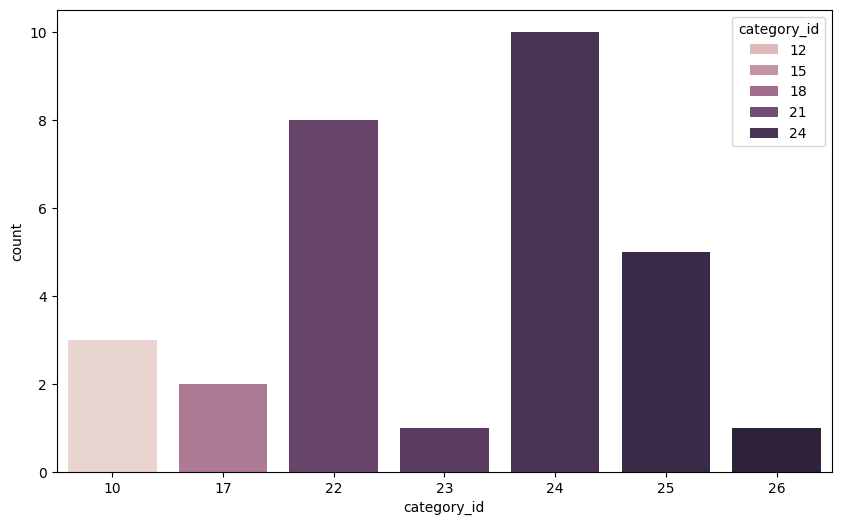

In [81]:
plt.figure(figsize=(10, 6))
sns.countplot(top_3_category, x='category_id', hue='category_id')
plt.show()

In [82]:
cont_table = pd.crosstab(top_3_category['country'], top_3_category['category_id'])
res = stats.chi2_contingency(cont_table)

res.statistic, res.pvalue

(40.0, 0.9221132189037747)

Due to a `pvalue` of 0.922, this tells us that we fail to reject the null hypothesis and there may be no significant difference between each countries top 3 category id's